# Hopfield Model and Data Reconstruction

### Authors
- Bezzi Filippo, *2148867*, filippo.bezzi@studenti.unipd.it
- Conte William, *2139490*, william.conte@studenti.unipd.it
- D'Amore Edoardo, *2152861*, edoardo.damore@studenti.unipd.it
- Gasparotto Giacomo, *2156362*, giacomo.gasparotto@studenti.unipd.it

### Supervisor
- Professor Baiesi Marco

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm
from scipy.special import erf
import seaborn as sns
from multiprocessing import Pool

In [26]:
colormap = cm.tab10

# Section 1: Hopfield Model definition and deterministic method for pattern reconstruction

A Hopfield Network is a simple mathematical model of a neural network. Each neuron's long range mean field interactions are given by the Hamiltonian:

$H[S]=-\frac{1}{2}\sum_{i\neq j} J_{ij}S_i S_j$.

The neurons are spins of two states $\pm 1$ and are fully connected among themselves. The couplings matrix $J$ models the synaptic connections among different neurons. Information is stored in the network by encoding in the coupling matrix whose elements are computed following the Hebbian learning rule

$J_{ij} = \frac{1}{N} \sum_{\mu}^{P} \xi_{i}^{\mu} \xi_{j}^{\mu}$,

where $\xi_{i}^{\mu}$ is the $i$-th spin of $\mu$-th patterns, with $i = 1, ..., N$ and $\mu = 1, ...,  P$. The coupling matrix is symmetric, with zero diagonal elements, meaning no self-connection.

Given the initial contiditions $\rho_i(t=0)$, the spins evolve iteratively following an update rule that, given the encoded couplings, computes the local magnetic field 

$h_i = \sum_j^N J_{ij} \rho_j$,

and assigns to that site the sign of $h_i$. In the following discussion spins are updated asynchronously, with each one single neuron at random updating its state at each iteration

$
S_i (t+1) = sgn(h_i).
$

In the Hopfield model $H$ is a Lyapunov function of the system, meaning it decreases along the dynamics and has minima at the stable **fixed points**, which correspond to the stored patterns. Over several iterations, the network will converge to the spin configuration associated with the closest local minima, that is to the fixed point that has the closest overlap with the initial conditions. The quantity that measures the similarity between the state of the network and a stored pattern is known as the **Mattis overlap** and is expressed as the normalized dot product of two spin configurations

$
m^\mu = \frac{1}{N} \sum_i^N S_i \xi_i^\mu
$.

During the update dynamics, the overlap is expected to increase towards the stored pattern if within its basin of attraction, which is defined as the set of initial conditions $\rho_i(t=0)$ such that the system converges to the stable fixed point. If the basin of attraction for a stored pattern $\xi^\mu$ is small then the network will perform worse to retrieve that pattern.

For increasing storage capacity $\alpha=\frac{P}{N}$ of the network, the basins of attraction of fixed points shrink and eventually **spurious states** dominate convergence of the network. Spurious states are additional dynamic stable states that are not part of the stored memories and appear as local minima. They essentially represent well-defined mixtures of several stored patterns. 

In the following discussion we will compute:
1. the energetic landscape of the Hopfield Model given the fixed points for different initial conditions and spurious states

2. the Mattis overlap and visualize how it changes depending on the initial conditions

3. the basins of attraction of the stored patterns' fixed points

4. the effect of the storage capacity on the appearance of spurious states

5. the critical storage capacity for the phase transition of the Hopfield Model from Ferromagnetic to Sping Glass phase.

### Bibliography
[1.1] D. J. C. MacKay, "Information Theory, Inference, and Learning Algorithms", Cambridge University Press (2003)

[1.2] D. J. Amit, H. Gutfreund, H. Sompolinsky, "Storing an Infinite Number of Patterns in a Spin-Glass Model of Neural Networks", *Physical Review Letters* 55 (1985) 1530–1533

[1.3] D. J. Amit, "Modeling Brain Functions: The world of attractor neural networks", Cambridge University Press (1989).

In [27]:
def generate_random_patterns(N, P):
    """ Generate homogeneous binary patterns (+1/-1) """
    xi = np.random.randint(0, 2, (P, N)) * 2 - 1 
    return xi

def weight_matrix(patterns):
    """ Compute Hopfield network weight matrix using Hebbian learning """
    num_patterns, N = patterns.shape
    J = np.tensordot(patterns, patterns, axes=(0, 0)) / N
    np.fill_diagonal(J, 0)
    return J

def noisify(pattern, noise):
    """ Add noise into patterns """
    noisy_pattern = pattern.copy()
    N = len(noisy_pattern)
    noises = np.random.choice(a=N, size=int(round(noise*N)), replace=False)
    noisy_pattern[noises] *= -1

    return noisy_pattern 

def energy_func(patterns, J):
    return -0.5 * patterns @ J @ patterns.T

def overlap(pattern_mu, pattern_nu):
    s    = pattern_nu
    xi    = pattern_mu
    return np.dot(s, xi) / s.size

def overlap_memory(pattern_mu, patterns_p):
    xi_P = patterns_p
    xi_mu = pattern_mu
    return np.dot(xi_P, xi_mu) / xi_mu.size

def retrieval_idx(retrieval, patterns):
    p_overlap = np.dot(patterns, retrieval) / patterns.shape[1]
    return np.argmax(abs(p_overlap))  

def network_flow(
    memory, J, noise, steps=100, EarlyStop=False, display=False,
    ):
    """ Computes the number of successfully retrieved patterns """
    #   patters:   set of stored patterns
    #   weights:   mean field couplings matrix
    #   noise:     fraction of bits to flip in the noisy pattern
    #   steps:     n iterations of asynchronous update rule
    #   display:   if True, shows energy of current state
    #   tolerance: number of iterations with no change in energy before stopping
    P, N = memory.shape
    
    # Vectorized noise addition
    noisy_patterns = memory * (2 * (np.random.rand(P, N) > noise) - 1)  
    overlap_init = np.array([np.dot(memory, noisy_patterns[mu]) / noisy_patterns[mu].size for mu in range(noisy_patterns.shape[0])])
    # Store attractors
    P_retrieved = np.zeros_like(noisy_patterns)
    suc_retrievals = np.zeros(P, dtype=int)
    spin_retrieval_acc = np.zeros(P)

    for p in range(P):
        P_retrieved[p] = update_pattern(noisy_patterns[p], J, steps, EarlyStop)
        
        p_overlap = np.dot(memory, P_retrieved[p]) / N
        
        idx = np.argmax(abs(p_overlap))  
        suc_retrievals[p] = (idx == p)
        
        spin_retrieval_acc[p] = p_overlap[p]

    if display: print(f"N: {N}, P: {P}, Patterns w/ {noise} noise shape: {noisy_patterns.shape}, Fraction of retrieved patterns: {np.mean(spin_retrieval_acc)}")
    
    return P_retrieved, noisy_patterns, np.mean(suc_retrievals), np.mean(spin_retrieval_acc), overlap_init
    
def update_pattern(input_pattern, J, steps=100, EarlyStop=False):
    """Asynchronous update with batch processing"""
    
    pattern = input_pattern.copy()
    N = len(pattern)
    steps_tot = steps * N
    prev_energy = None
    
    for _ in range(steps_tot):
        i = np.random.randint(0, N)
        pattern[i] = np.sign(np.dot(J[i], pattern))

        if EarlyStop:
            current_energy = -0.5 * np.dot(pattern, J @ pattern.T)
            if prev_energy is not None and abs(current_energy - prev_energy) < 1e-5:
                break
            prev_energy = current_energy
    
    return pattern

def storage_capacity(N_list, P_range, noise=0.1):
    """ Analyze max storage capacity change for increasing network size """
    capacity = []
    for N in N_list:
        max_stored = 0
        patterns = generate_random_patterns(int(N), max(P_range))
        J = weight_matrix(patterns)
        for P in P_range:
            _, _, accuracy, _, _ = network_flow(patterns[:P], J, noise, steps=50, EarlyStop=True)
            if accuracy < 0.99:
                break
            max_stored = P  
        capacity.append(max_stored / N)
    return np.array(capacity)

def visualize_energy_distribution(stored_patterns, noisy_patterns, J, noise):
    stored_energies = [energy_func(sp, J) for sp in stored_patterns]
    noisy_energies  = [energy_func(ic, J) for ic in noisy_patterns] 
    
    sns.kdeplot(stored_energies,   label="Memory (Stable)", color="blue", fill=True)
    sns.kdeplot(noisy_energies,    label=f"Noise {noise} (Initial Condition)", color="orange", fill=True)
    plt.xlabel("Energy")
    plt.ylabel("Density")
    plt.grid(True)
    plt.title("Energy Distribution of States (KDE)")
    plt.legend()
    plt.show()

def compute_crosstalk(N, P, num_trials):
    crosstalk = []
    if P == 1:
        return np.array([0])
    for _ in range(num_trials):
        patterns = np.random.choice([-1, 1], size=(P, N))
        nu = 0
        other_patterns = np.delete(patterns, nu, axis=0)
        cross_term = (1 / N) * np.dot(other_patterns.T, other_patterns @ patterns[nu])
        crosstalk.append(cross_term)

    return np.array(crosstalk).flatten()

def visualize_patterns(patterns, title="Patterns"):
        N = patterns.shape[1]
        fig, axes = plt.subplots(1, len(patterns), figsize=(9, 3))
        for i, pattern in enumerate(patterns):
            axes[i].imshow(pattern.reshape(int(np.sqrt(N)), int(np.sqrt(N))), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f"Pattern {i+1}")
        plt.suptitle(title)
        plt.show()

def generate_my_patterns(N, P):
    my_p = np.array([
        [np.where(np.cos(x) > 0.1, 1, -1) for x in range(N)],
        [np.where(np.sin(x) > 0.85, 1, -1) for x in range(N)],
        [np.where(np.log(x) > 4, 1, -1) for x in range(1, N+1)]
    ])
    return np.concatenate((my_p, generate_random_patterns(N, P=P-3)), axis=0)

def generate_spurious_states(patterns):
    P, N = patterns.shape
    spurious_states = []
    
    for _ in range(P):
        mu1, mu2, mu3 = np.random.choice(P, 3, replace=False)
        spurious_state = np.sign(patterns[mu1] + patterns[mu2] + patterns[mu3])
        spurious_states.append(spurious_state)
    
    return np.array(spurious_states)

In [28]:
# ENERGY
N, P, noise = 100, 6, 0.2
my_patterns = generate_my_patterns(N, P)
my_noisy_patterns = np.array([noisify(p, noise) for p in my_patterns])
my_spurious_patterns = generate_spurious_states(my_patterns)
random_states     = generate_random_patterns(N, P)

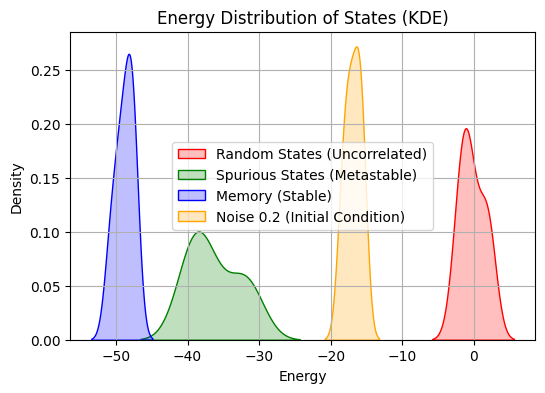

In [29]:
J = weight_matrix(my_patterns)
stored_energies   = [energy_func(p, J)  for p in my_patterns]
spurious_energies = [energy_func(p, J)  for p  in my_spurious_patterns]
noisy_energies    = [energy_func(p, J)  for p in my_noisy_patterns]
random_energies   = [energy_func(p, J) for p in random_states]

plt.figure(figsize=(6, 4))
sns.kdeplot(random_energies,   label="Random States (Uncorrelated)", color="red",   fill=True)
sns.kdeplot(spurious_energies,   label="Spurious States (Metastable)", color="green", fill=True)
visualize_energy_distribution(my_patterns, my_noisy_patterns, J, noise)

In the above occupancy plot we visualize the energy densities of three spurious metastable states generate by the mixture $\xi_i^{sp}=sign(\pm\xi_i^{\mu_1}\pm \xi_i^{\mu_2}\pm \xi_i^{\mu_3})$.

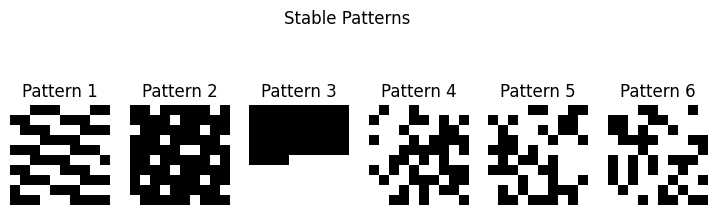

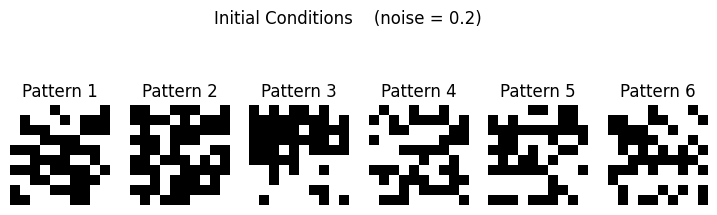

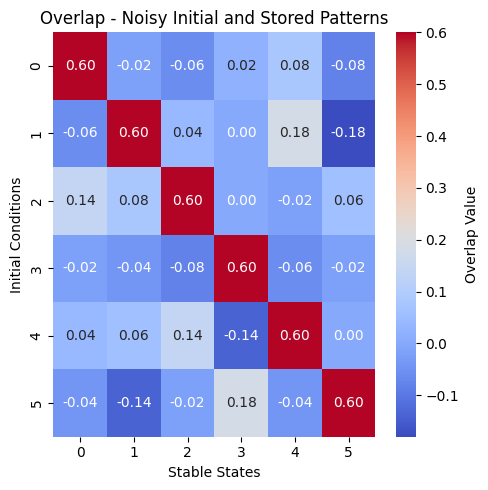

In [30]:
visualize_patterns(my_patterns, title="Stable Patterns")
visualize_patterns(my_noisy_patterns, title=f"Initial Conditions    (noise = {noise})")

overlap_matrix = np.array([overlap_memory(my_noisy_patterns[i], my_patterns) for i in range(my_patterns.shape[0])])
plt.figure(figsize=(5, 5))
sns.heatmap(overlap_matrix, annot=True, cmap="coolwarm", cbar_kws={'label': 'Overlap Value'}, fmt=".2f")
plt.xlabel("Stable States")
plt.ylabel("Initial Conditions")
plt.title("Overlap - Noisy Initial and Stored Patterns")
plt.tight_layout()
plt.show()

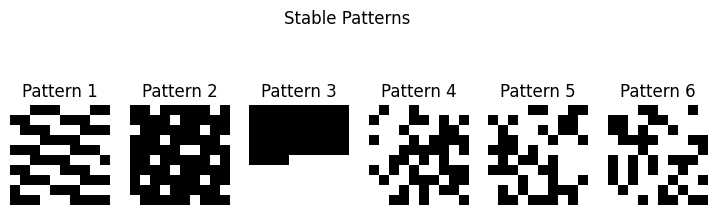

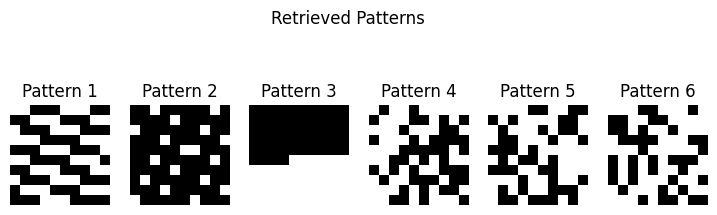

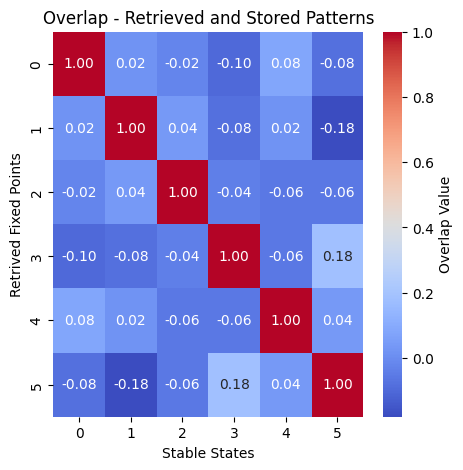

In [31]:
my_retrieved_patterns = np.array([update_pattern(p, J, steps=200) for p in my_noisy_patterns])
visualize_patterns(my_patterns, title="Stable Patterns")
visualize_patterns(my_retrieved_patterns, title="Retrieved Patterns")

overlap_r_matrix = np.array([overlap_memory(my_retrieved_patterns[i], my_patterns) for i in range(my_patterns.shape[0])])
plt.figure(figsize=(5, 5))
sns.heatmap(overlap_r_matrix, annot=True, cmap="coolwarm", cbar_kws={'label': 'Overlap Value'}, fmt=".2f")
plt.xlabel("Stable States")
plt.ylabel("Retrived Fixed Points")
plt.title("Overlap - Retrieved and Stored Patterns")
plt.show()

In [32]:
noises = np.linspace(0, 1, 10)
num_trials = 20

P_set_shape = (len(noises), my_patterns.shape[0], my_patterns.shape[1])
retrieval_set = np.zeros(P_set_shape)
overlap_init_set = np.zeros((len(noises), my_patterns.shape[0], my_patterns.shape[0]))
noisy_set = np.zeros(P_set_shape)
frac_suc_ret_set = np.zeros(len(noises))
spin_ret_acc_set = np.zeros(len(noises))

for i, noise in enumerate(noises):
    trial_retrievals = []
    trial_overlaps = []
    trial_noisy_patterns = []
    trial_frac_success = []
    trial_spin_acc = []

    for _ in range(num_trials):
        retrieved_P, noisy_P, frac_suc_ret, spin_ret_acc, overlap_init = network_flow(my_patterns, J, noise)

        trial_retrievals.append(retrieved_P)
        trial_noisy_patterns.append(noisy_P)
        trial_frac_success.append(frac_suc_ret)
        trial_spin_acc.append(spin_ret_acc)
        trial_overlaps.append(overlap_init)

    retrieval_set[i] = np.mean(trial_retrievals, axis=0)
    noisy_set[i] = np.mean(trial_noisy_patterns, axis=0)
    frac_suc_ret_set[i] = np.mean(trial_frac_success)
    spin_ret_acc_set[i] = np.mean(trial_spin_acc)
    overlap_init_set[i] = np.mean(trial_overlaps, axis=0)

frac_suc_ret_err = np.std(trial_frac_success)
spin_ret_acc_err = np.std(trial_spin_acc)

frac_suc_ret_err = np.std(trial_frac_success)
spin_ret_acc_err = np.std(trial_spin_acc)

mean_self_overlap = np.mean(np.diagonal(overlap_init_set, axis1=1, axis2=2), axis=1)

mean_sys_overlap = np.array([
        np.mean([
            np.max(
                [overlap_init_set[n, i, j]
                for j in range(overlap_init_set.shape[1]) 
                if j!=i]
                )
        for i in range(overlap_init_set.shape[1])])
        for n in range(overlap_init_set.shape[0])
    ])

mean_self_overlap_err = np.std(np.diagonal(overlap_init_set, axis1=1, axis2=2), axis=1)
mean_sys_overlap_err = np.array([
    np.std([
        np.max([overlap_init_set[n, i, j] for j in range(overlap_init_set.shape[1]) if j != i])
        for i in range(overlap_init_set.shape[1])
    ])
    for n in range(overlap_init_set.shape[0])
])

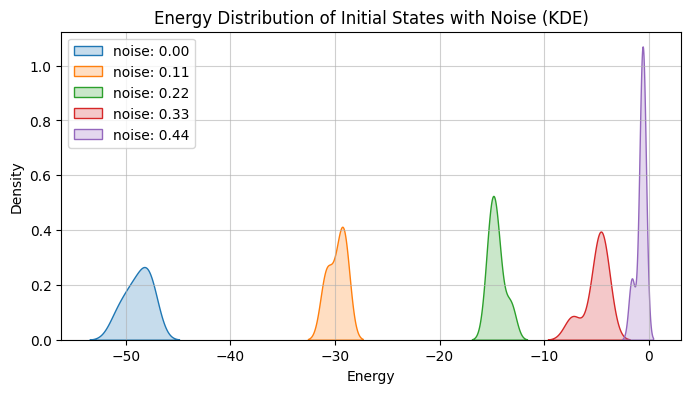

error:         	0.00	0.11	0.22	0.33	0.44	0.56	0.67	0.78	0.89	1.00
accuracy:	1.00	1.00	0.98	0.87	0.29	-0.33	-0.79	-1.00	-1.00	-1.00


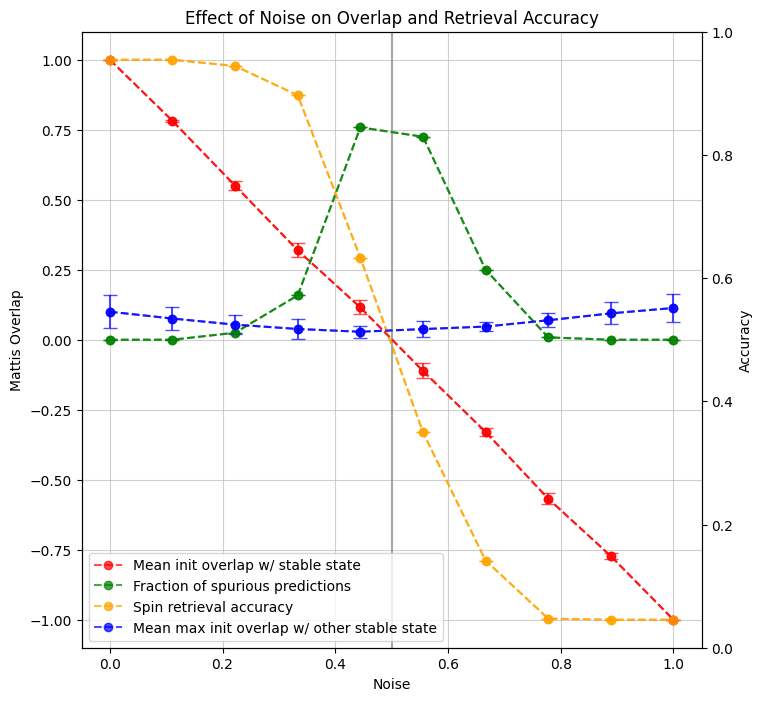

In [33]:
J = weight_matrix(my_patterns)
noisy_energies_set = np.array([[energy_func(p, J) for p in sp] for sp in noisy_set])
noisy_energies_set.shape

plt.figure(figsize=(8,4))
plt.grid(alpha=0.6)
for i, energies in enumerate(noisy_energies_set[:5]):
    sns.kdeplot(energies, label=f"noise: {noises[i]:.2f}", fill=True)

plt.xlabel("Energy")
plt.ylabel("Density")
plt.title("Energy Distribution of Initial States with Noise (KDE)")
plt.legend()
plt.show()

print(f"error:         \t{noises[0]:.2f}\t{noises[1]:.2f}\t{noises[2]:.2f}\t{noises[3]:.2f}\t{noises[4]:.2f}\t{noises[5]:.2f}\t{noises[6]:.2f}\t{noises[7]:.2f}\t{noises[8]:.2f}\t{noises[9]:.2f}")
print(f"accuracy:\t{spin_ret_acc_set[0]:.2f}\t{spin_ret_acc_set[1]:.2f}\t{spin_ret_acc_set[2]:.2f}\t{spin_ret_acc_set[3]:.2f}\t{spin_ret_acc_set[4]:.2f}\t{spin_ret_acc_set[5]:.2f}\t{spin_ret_acc_set[6]:.2f}\t{spin_ret_acc_set[7]:.2f}\t{spin_ret_acc_set[8]:.2f}\t{spin_ret_acc_set[9]:.2f}")


plt.figure(figsize=(8, 8))
plt.grid(alpha=0.6)

plt.plot(noises, mean_self_overlap,    marker="o", linestyle="--", alpha=0.7, label="Mean init overlap w/ stable state", color='red')
plt.errorbar(noises, mean_self_overlap,  yerr=mean_self_overlap_err, marker="o", linestyle="--", alpha=0.7, capsize=5, color='red')

plt.plot(noises, 1-frac_suc_ret_set,   marker="o", linestyle="--", alpha=0.7, label="Fraction of spurious predictions", color='green')
plt.errorbar(noises, 1-frac_suc_ret_set, yerr=frac_suc_ret_err,      marker="o", linestyle="--", alpha=0.7, capsize=5, color='green')

plt.plot(noises, spin_ret_acc_set,     marker="o", linestyle="--", alpha=0.7, label="Spin retrieval accuracy ", color='orange')
plt.errorbar(noises, spin_ret_acc_set,   yerr=spin_ret_acc_err,      marker="o", linestyle="--", alpha=0.7, capsize=5, color='orange')

plt.plot(noises, mean_sys_overlap,     marker="o", linestyle="--", alpha=0.7, label="Mean max init overlap w/ other stable state", color='blue')
plt.errorbar(noises, mean_sys_overlap,   yerr=mean_sys_overlap_err,  marker="o", linestyle="--", alpha=0.7, capsize=5, color='blue')

plt.axvline(x=0.5, color='gray', linestyle="-", alpha=0.7)
plt.legend(loc="lower left")
plt.xlabel("Noise")
plt.ylabel("Mattis Overlap")
plt.title("Effect of Noise on Overlap and Retrieval Accuracy")

ax2 = plt.gca().twinx()
ax2.set_ylabel("Accuracy")
plt.show()

Noise is added randomly flipping the value of a spin. As two opposite spin configurations are energetically equivalent. Beyond 50% noise the network will converge to the reverse states.

From the above graphs we see that noise not only raises the energetic configuration of the initial conditions, but it also reduces the overlap of the initial conditions with the stored patterns. In the above graph we indeed see that beyond a threshold (around $m=0.5$) the network becomes unstable, with retrieval of spurious states becoming dominant. 

In [34]:
trials = 100
q_params = np.linspace(0, 0.5, 20)
patterns = my_patterns
P = patterns.shape[0]
J = weight_matrix(patterns)

retrieval_rates = []
overlaps = []
overlaps_std = []
for q in q_params:
    success_count = 0
    total_count = P * trials
    overlap_values = []
    
    for mu in range(P):
        for _ in range(trials):
            noisy_pattern = noisify(patterns[mu], q)
            overlap_initial = np.dot(patterns[mu], noisy_pattern) / N
            overlap_values.append(overlap_initial)

            retrieved = update_pattern(noisy_pattern, J, steps=50)
            
            if np.array_equal(retrieved, patterns[mu]):
                success_count += 1
    
    retrieval_rates.append(success_count / total_count)
    overlaps.append(np.mean(overlap_values))
    overlaps_std.append(np.std(overlap_values))
    
retrieval_rates = np.array(retrieval_rates)
overlaps = np.array(overlaps)
overlaps_std = np.array(overlaps_std)

below_threshold = np.where(retrieval_rates < 0.5)[0]
m_critical = overlaps[below_threshold[0]]

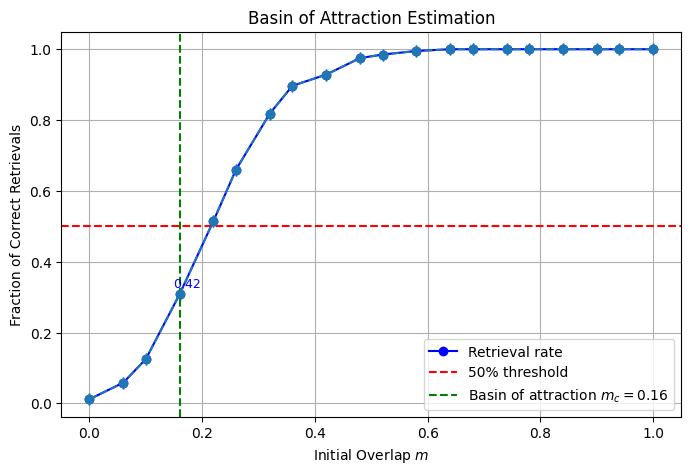

In [35]:
plt.figure(figsize=(8, 5))

plt.plot(overlaps, retrieval_rates, marker='o', linestyle='-', label="Retrieval rate", color="blue")
plt.errorbar(x=overlaps, y=retrieval_rates, xerr=overlaps_std, marker='o', linestyle="--", capsize=4)

plt.axhline(y=0.5, color='r', linestyle='--', label="50% threshold")
plt.axvline(x=m_critical, color='g', linestyle='--', label=f"Basin of attraction $m_c={m_critical:.2f}$")
plt.xlabel("Initial Overlap $m$")
plt.ylabel("Fraction of Correct Retrievals")

mask_c = np.where(overlaps ==  m_critical)[0]
q_c = q_params[mask_c][0]
plt.annotate(f"{q_c:.2f}", (overlaps[mask_c], retrieval_rates[mask_c]), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=9, color="blue")

plt.title("Basin of Attraction Estimation")
plt.legend()
plt.grid()
plt.show()

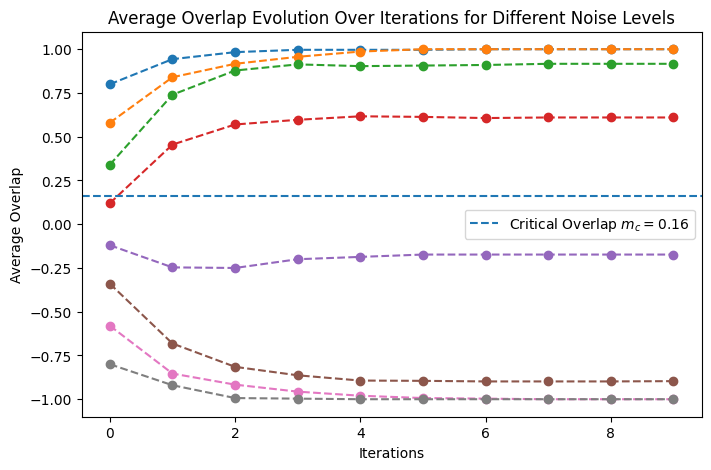

In [36]:
steps = 10
q_params = np.linspace(0.1, 0.9, 8)
plt.figure(figsize=(8, 5))
for q in q_params:
    my_noisy_patterns = np.array([noisify(pattern, q) for pattern in patterns])
    overlap_tracking = np.zeros((P, steps))
    for p in range(P):
        pattern = my_noisy_patterns[p].copy()
        for t in range(steps):
            overlap_tracking[p, t] = overlap(pattern, patterns[p])
            pattern = update_pattern(pattern, J, steps=1)
    plt.plot(np.mean(overlap_tracking, axis=0), marker='o', linestyle="--")

plt.axhline(y=m_critical, linestyle='--', label=f"Critical Overlap $m_c={m_critical:.2f}$")
plt.xlabel("Iterations")
plt.ylabel("Average Overlap")
plt.title("Average Overlap Evolution Over Iterations for Different Noise Levels")
plt.legend()
plt.show()

So far we have seen that a finite set of patterns $P<<N$ an initial condition with a limited error fed to the network converges to its stable state. Say at $t=0$ we "place" $i$-th spin of the initial condition in the network and compute the local magnetic field $h_i = \frac{1}{N} \sum_{j} J_{ij} p_j$. Say we pick a stored pattern $\xi^\nu$, we find that $h_i = \xi_i^\nu + C_{i}^{\nu}$, where $C_{i}^{\nu}$ is known as the "cross-talk" term. It contributes to the local field causing the appearance of additional dynamically stable states. The cross-talk term is proportional to the overlap of our initial condition and all other patterns, then the higher the density of memorized patterns in the network the more spurious states will appear.

In the following analysis we will see how the network's storage capacity $\frac{P}{N}$ affects the value of the cross-talk terms.

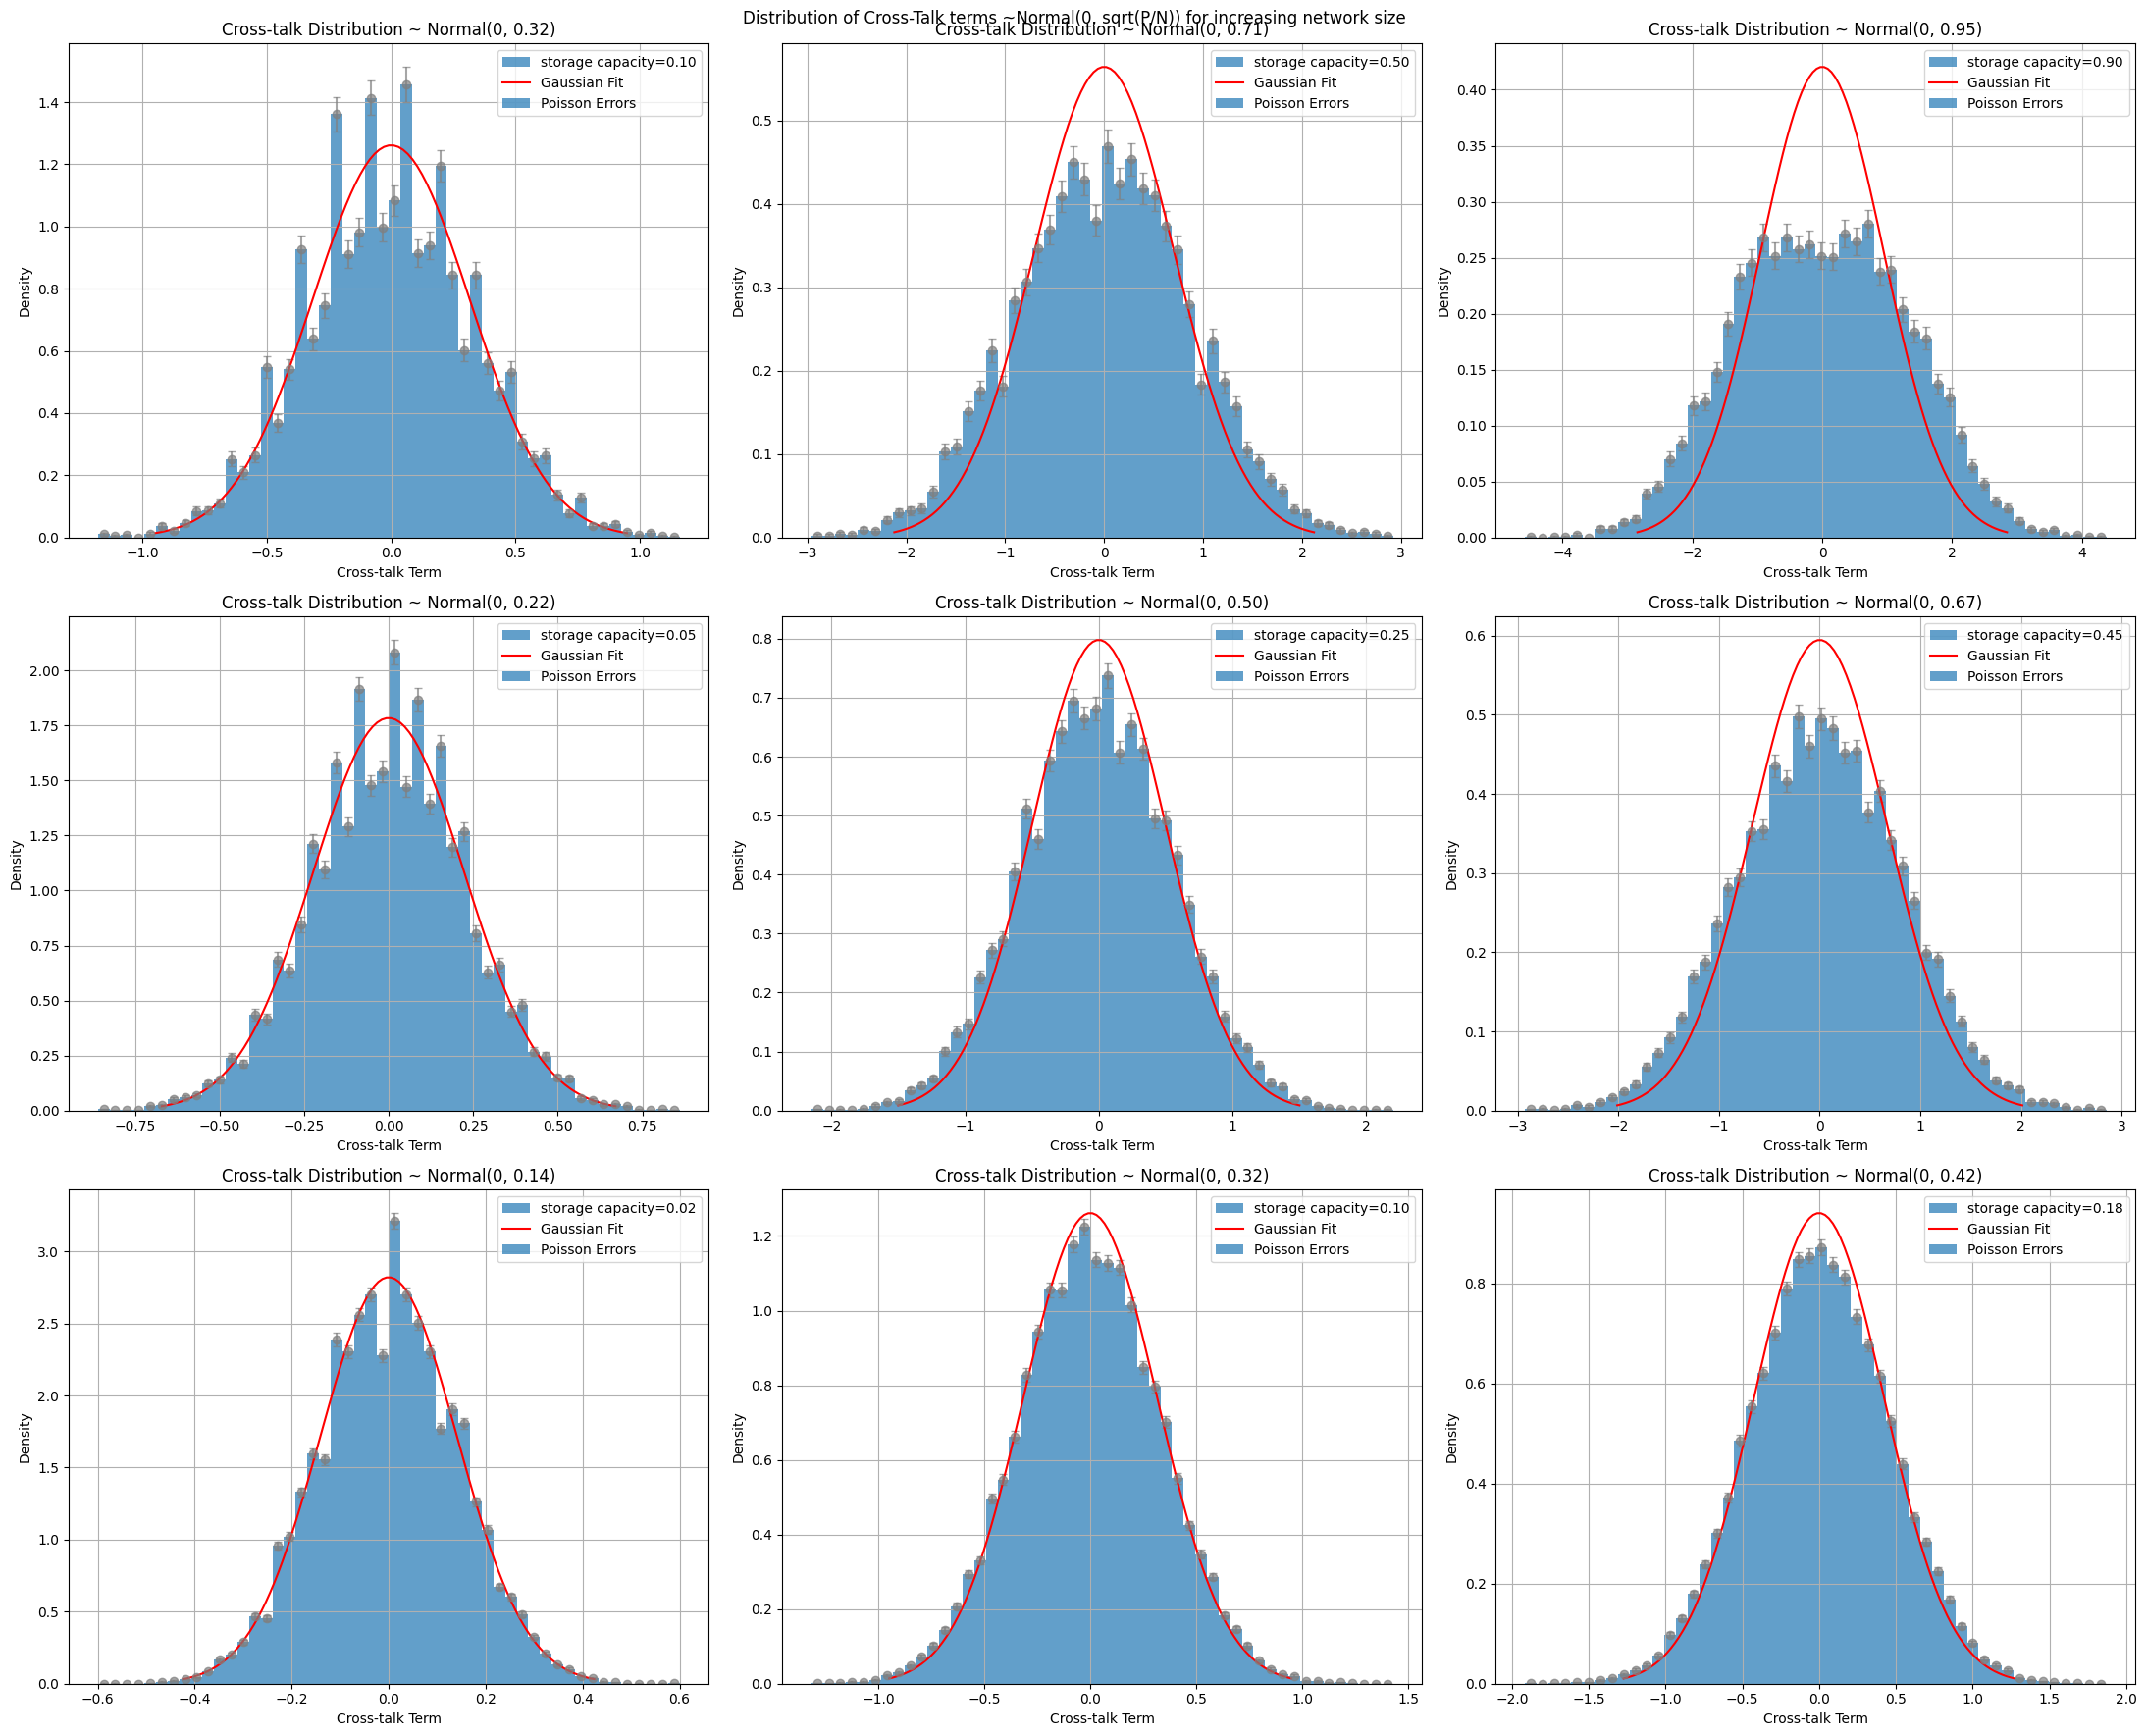

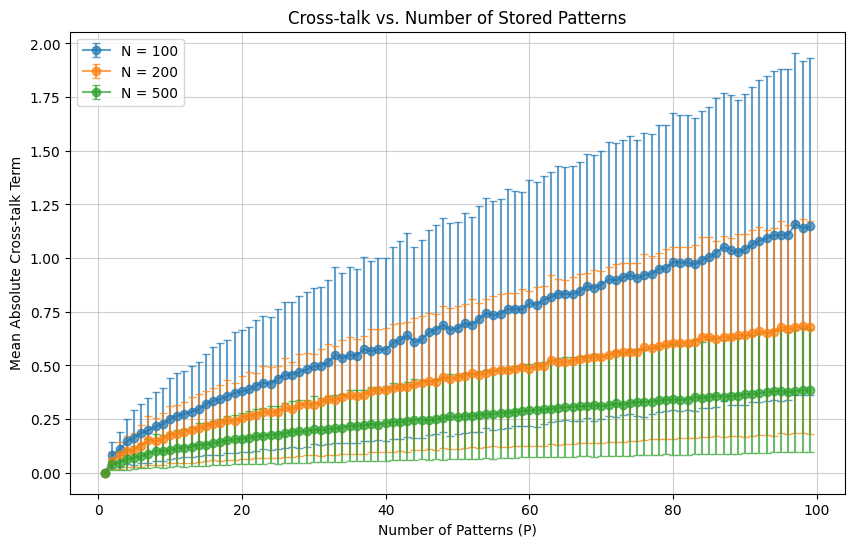

In [ ]:
N_values = [100, 200, 500]
P_values = np.arange(1, 100, 1)
num_trials = 100 

crosstalk_distributions = {}

for N in N_values:
    crosstalk_distributions[N] = []
    for P in P_values:
        crosstalk = compute_crosstalk(N, P, num_trials)
        crosstalk_distributions[N].append(crosstalk)

plt.figure(figsize=(20, 20))

for j, N in enumerate(N_values):
    for i, P in enumerate([10, 50, 90]):
        plt.subplot(len(N_values), 3, j*3 + i + 1)
        p = P_values[P_values == P][0]
        
        counts, bin_edges, _ = plt.hist(crosstalk_distributions[N][p], bins=50, density=True, alpha=0.7, label=f"P={P}")
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        
        bin_counts = counts * len(crosstalk_distributions[N][p]) * (bin_edges[1] - bin_edges[0])
        errors = np.sqrt(bin_counts) / len(crosstalk_distributions[N][p]) / (bin_edges[1] - bin_edges[0])
        
        plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', alpha=0.7, color='grey', capsize=3, label="Poisson Errors")

        mu, sigma = 0, np.sqrt(P/N)
        x = np.linspace(-3*sigma, 3*sigma, 100)
        plt.plot(x, norm.pdf(x, mu, sigma), color='red', label="Gaussian Fit")
        plt.xlabel("Cross-talk Term")
        plt.ylabel("Density")
        plt.title(f"Cross-talk Distribution ~ Normal(0, {np.sqrt(P/N):.2f})")
        plt.legend([f"storage capacity={P/N:.2f}", "Gaussian Fit", "Poisson Errors"])
        plt.grid(True)
plt.suptitle("Distribution of Cross-Talk terms ~Normal(0, sqrt(P/N)) for increasing network size")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.grid(alpha=0.6)

for N in N_values:
    mean_crosstalk = []
    std_crosstalk = []

    for i in range(len(P_values)):
        abs_crosstalk = np.abs(crosstalk_distributions[N][i])
        mean_crosstalk.append(np.mean(abs_crosstalk))
        std_crosstalk.append(np.std(abs_crosstalk))
    
    mean_crosstalk = np.array(mean_crosstalk)
    std_crosstalk = np.array(std_crosstalk)
    
    plt.errorbar(P_values, mean_crosstalk, yerr=std_crosstalk, marker='o', linestyle='-', capsize=3, label=f"N = {N}", alpha=0.7)

plt.xlabel("Number of Patterns (P)")
plt.ylabel("Mean Absolute Cross-talk Term")
plt.title("Cross-talk vs. Number of Stored Patterns")
plt.legend()
plt.show()

For each iteration, if the cross-talk term $|C|<1$ spins will aline correctly with their stable state's field, otherwise spurious metastable states dominate the dynamics of the system.

As a function of increasing $p$, we can find the largest $p_{max}$ beyond which spurious states retrieval becomes dominant. The maximum storage capacity of a Hopfield Network is then defined as   $\alpha_C=\frac{p_{max}}{N}$. It the value of the ratio of $N$ and $P$ such that the probability that $|C|>1$ is less than 1%. In the following, we will check that for our model $\alpha_C$ converges to the theoretical value at large $N$, $\alpha_c=0.138$.

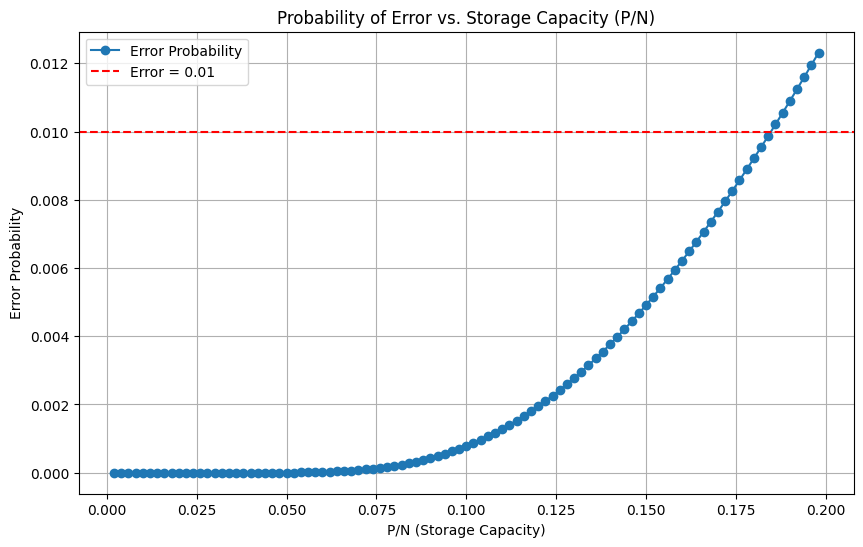

Maximum Storage Capacity (Error = 0.01): α_C = 0.184


In [38]:
errors = []
for P in P_values:
    sigma = np.sqrt(P / N)
    error = 0.5 * (1 - erf(1 / (np.sqrt(2) * sigma)))
    errors.append(error)

plt.figure(figsize=(10, 6))
plt.plot(P_values / N, errors, marker='o', linestyle='-', label="Error Probability")
plt.axhline(y=0.01, color='red', linestyle='--', label="Error = 0.01")
plt.xlabel("P/N (Storage Capacity)")
plt.ylabel("Error Probability")
plt.title("Probability of Error vs. Storage Capacity (P/N)")
plt.legend()
plt.grid(True)
plt.show()

max_capacity = P_values[np.argmin(np.abs(np.array(errors) - 0.01))] / N
print(f"Maximum Storage Capacity (Error = 0.01): α_C = {max_capacity:.3f}")

In [39]:
N_list = list(range(10, 500, 10))
trials = 20

capacities = []
for _ in range(trials):
    capacity = storage_capacity(N_list, P_range=range(1, 75, 1))
    capacities.append(capacity)
    
mean_capacity = np.mean(capacities, axis=0)
std_capacity  = np.std(capacities, axis=0)

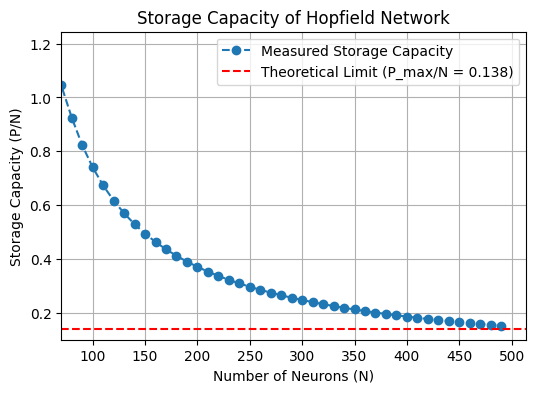

In [40]:
plt.figure(figsize=(6, 4))
plt.plot(N_list, mean_capacity, marker="o", linestyle="--", label="Measured Storage Capacity")
#plt.errorbar(N_list, mean_capacity, yerr=std_capacity, alpha=0.5, label="Measured Storage Capacity", capsize=3)
plt.axhline(y=0.138, color='r', linestyle="--", label="Theoretical Limit (P_max/N = 0.138)")
plt.xlabel("Number of Neurons (N)")
plt.ylabel("Storage Capacity (P/N)")
plt.xlim((70))
plt.legend()
plt.grid()
plt.title("Storage Capacity of Hopfield Network")
plt.show()
#print("Mean standard deviation:", np.mean(std_capacity))

Then for increasing values of $\alpha$ we expect the phase transition from Ferromagnetic to Spin Glass phase occurs around $\alpha_C$.

In [ ]:
N_values = [50, 100, 200, 500]
alpha_values = np.linspace(0.01, 0.2, 20)
trials = 10

phase_transition_results = {}

for N in N_values:
    phase_diagram = []
    
    for alpha in alpha_values:
        P = int(alpha * N)
        patterns = generate_random_patterns(N, P)
        J = weight_matrix(patterns)

        retrieval_success = []
        for _ in range(trials):
            noisy_patterns = np.array([noisify(p, 0.1) for p in patterns])
            retrieved_patterns = np.array([abs(update_pattern(p, J, steps=50)) for p in noisy_patterns])
            retrievals = [np.array_equal(retrieved_patterns[i], patterns[i]) for i in range(P)]
            if len(retrievals) > 0: retrieval_mean = np.mean(retrievals)
            else: retrieval_mean = np.nan
            retrieval_success.append(retrieval_mean)

        if len(retrieval_success) > 0: mean_success = np.mean(retrieval_success)
        else: mean_success = np.nan
        
        phase_diagram.append(mean_success)
        
    phase_transition_results[N] = np.array(phase_diagram)

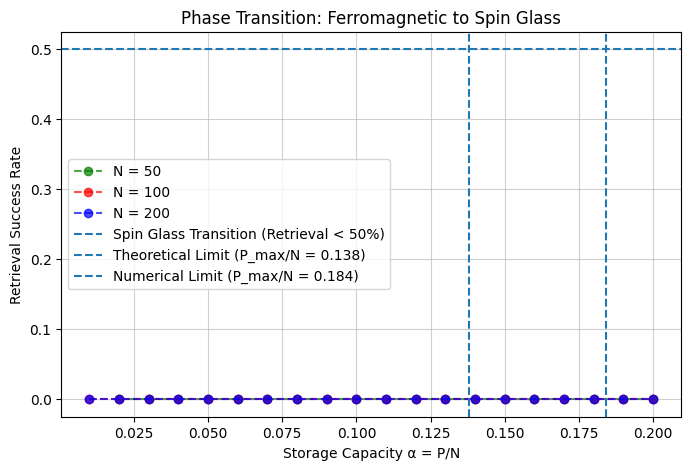

In [ ]:
plt.figure(figsize=(8, 5))
plt.grid(alpha=0.6)
colors = ["green", "red", "blue"]
for N, success_rates in phase_transition_results.items():
    plt.plot(alpha_values, success_rates, alpha=0.7, marker="o", linestyle="--", label=f"N = {N}", color=colors[N_values.index(N)])
    plt.legend()

plt.axhline(0.5, linestyle="--", label="Spin Glass Transition (Retrieval < 50%)")
plt.axvline(x=0.138, linestyle="--", label="Theoretical Limit (P_max/N = 0.138)")
plt.axvline(x=max_capacity, linestyle="--", label="Numerical Limit (P_max/N = 0.184)")
plt.xlabel("Storage Capacity α = P/N")
plt.ylabel("Retrieval Success Rate")
plt.title("Phase Transition: Ferromagnetic to Spin Glass")
plt.legend()
plt.show()

# Section 2: Pattern reconstruction using Monte Carlo methods and Metropolis algorithm


In this section, we will perform pattern reconstruction by employing stochastic approaches such as the Monte Carlo method, with the Metropolis algorithm as a tool for this purpose.
Each stored pattern corresponds to a local minimum in the network's energy landscape, and the network evolves towards these minima from an initial corrupted configuration.
The energy of a Hopfield network is given by:

\begin{equation*}
  E = -\frac{1}{2} \sum_{i \neq j} J_{ij} S_i S_j
\end{equation*}

The Monte Carlo method consists of first randomly sampling a spin in the pattern and then applying Metropolis algorithm, where iteratively the states of the spins are updated based on transition probabilities that favor moves towards lower energy configurations while still allowing occasional uphill moves.

Metropolis algorithm works in this way:
1. For each randomly selected spin, we compute the energy difference $\Delta E$ between the pattern's configuration with that spin and the one with the spin flipped. In particular,  $\Delta E$ in this context si equal to:
\begin{equation*}
  \Delta E = 2 S_i \big( \sum_{j = 1}^N J_{ij} S_j \big)
\end{equation*}
2. If $\Delta E$ is negative, we accpet the spin flip. If not, we generate a random number x from a uniform distribution $\in$ [0,1] and we accept the spin flip if x < $\exp(-\beta \Delta E)$.
Here $\beta$ = $\frac{1}{T}$ (we have set $K_b$ = 1).

The parameter $\beta$ controls the probability of accepting a move that increases energy (which is given by the exponential Boltzmann factor). 
In this analysis we will study the stability of the system and the retrieval ability of the network.

**Note**: In the following sections, we will use the Mattis overlap order parameter [2.1], defined as:
\begin{equation*}
  m_\mu = \frac{1}{N} \sum_{i=1}^{N} S_i^{(\mu)} S_i 
\end{equation*}

to compute the overlap between the retrieved pattern and the stored ones. When we refer to **accuracy**, we mean the correct fraction of the **retrieved pattern** compared to the **selected original pattern**. The term **overlap**, instead, refers to the degree of similarity between the retrieved pattern and the other stored patterns.

**Bibliography:**

[2.1] Fachechi, A., Agliari, E. & Barra, A. Dreaming neural networks: forgetting spurious memories
and reinforcing pure ones. Neural Networks 112, 24–40 (2019).



## Functions for 1D patterns

In [51]:
# this function will be used later in section 4
def metropolis_1d(corrupted, weights, T, steps): #MonteCarlo + Metropolis
    beta = 1/T
    pattern_copy = corrupted.copy()
    
    for _ in range(steps):
        i = np.random.randint(0,len(corrupted))
        hi = np.sum(weights[i] * pattern_copy)
        Delta_E = 2 * pattern_copy[i] * hi
        x = np.random.random()
        
        #Metropolis condition:
        if Delta_E < 0 or x < np.exp(-beta * Delta_E):
            pattern_copy[i] *= -1
    return pattern_copy
    
def compute_weights_1d(patterns): #compute the weight matrix
    N_spins = patterns.shape[1]
    weight_matrix = (1/N_spins) * np.outer(patterns[0],patterns[0])
    for i in range(1,patterns.shape[0]):
        weight_matrix += (1/N_spins) * np.outer(patterns[i],patterns[i])
    np.fill_diagonal(weight_matrix, 0)
    return weight_matrix

def compute_energy_1d(pattern, weights): #compute the energy
    E = -0.5 * np.dot(pattern, np.dot(weights, pattern))
    return E

def mattis_overlap_1d(pattern, retrieved): #compute the Mattis overlap
    return (1/len(pattern)) * np.dot(pattern.reshape(-1),retrieved.reshape(-1))

## Functions for 2D patterns

In [52]:
def create_patterns_2d(rows,columns,N_patterns): #mu patterns, each one composed by a matrix of rows x columns spins
    patterns = []
    for _ in range(N_patterns):
        pattern = np.random.randint(0,2,size = (rows,columns)) * 2 -1
        patterns.append(pattern)
    return np.array(patterns)


def compute_weights_2d(patterns): #compute the weight matrix
    N_spins = patterns.shape[1] * patterns.shape[2]
    weight_matrix = (1/N_spins) * np.outer(patterns[0],patterns[0])
    for i in range(1,patterns.shape[0]):
        weight_matrix += (1/N_spins) * np.outer(patterns[i],patterns[i])
    np.fill_diagonal(weight_matrix, 0)
    return weight_matrix

def compute_energy_2d(pattern, weights): #compute the energy
    E = -0.5 * np.dot(pattern.reshape(-1), np.dot(weights, pattern.reshape(-1))) #flattens the matrix in a 1d array
    return E

def pattern_corruption_2d(pattern,q): #randomly flip a fraction of the spins in a pattern
    rows = pattern.shape[0]
    columns = pattern.shape[1]
    corrupted = pattern.reshape(-1).copy()
    flip_numbers = int(np.floor((len(corrupted) * q)))
    flip_indices = np.random.choice(len(corrupted), flip_numbers, replace = False)
    corrupted[flip_indices] *= -1
    return corrupted.reshape(rows,columns)

def metropolis_2d(corrupted, weights, T, steps): #MonteCarlo + Metropolis
    beta = 1/T
    rows = corrupted.shape[0]
    columns = corrupted.shape[1]
    pattern_copy = corrupted.reshape(-1).copy()
    
    for _ in range(steps):
        i = np.random.randint(0,rows * columns)
        hi = np.sum(weights[i] * pattern_copy)
        Delta_E = 2 * pattern_copy[i] * hi
        x = np.random.random()
        
        #Metropolis condition:
        if Delta_E < 0 or x < np.exp(-beta * Delta_E):
            pattern_copy[i] *= -1
    return pattern_copy.reshape(rows,columns)

def select_pattern_2d(patterns): #choose randomly a pattern
    return np.random.randint(0,patterns.shape[0])

def mattis_overlap_2d(pattern, retrieved): #compute the Mattis overlap
    N_spins = pattern.shape[0] * pattern.shape[1]
    return (1/N_spins) * np.dot(pattern.reshape(-1),retrieved.reshape(-1))

## 1) Stability analysis

With the term "stability" we mean the ability of the algorithm to converge to the correct pattern given as input exactly one of the stored pattern.
We will check it for:
- Different range of **temperatures**
- Different number of **iterations** of the Metropolis algorithm

### Stability for different temperatures

First we store some patterns in the network:

In [53]:
#Store patterns in memory
# for reproducibility
np.random.seed(1234)
runs = 100 #number of simulations for a given value of T

rows,columns = 10,10 #patterns are square matrix with 100 spins
N_patterns = 6 #number of stored patterns
patterns = create_patterns_2d(rows,columns,N_patterns) 
J = compute_weights_2d(patterns) #compute the weight matrix of the stored patterns

We now check the stability of the retrieval for different values of temperature:

<ErrorbarContainer object of 3 artists>

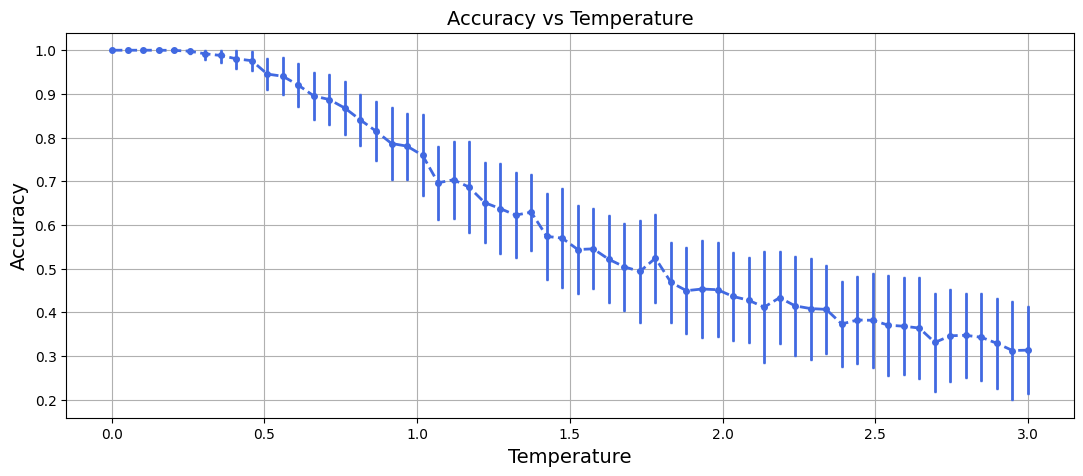

In [54]:
steps = 100 #steps for the Metropolis algorithm
T = np.linspace(0.001,3,60) #array of temperatures
accuracy_list = [] #we will check accuracy by the use of Matti's order parameter
upper_errors = [] #store upper error bounds
lower_errors = [] #store lower error bounds

for temperature in T:
    accuracy = []
    for _ in range(runs): #we compute the accuracy "runs" times for each temperature and then take the mean
        i = select_pattern_2d(patterns)
        corrupted = pattern_corruption_2d(patterns[i],0) # zero corruption of the pattern
        retrieved = metropolis_2d(corrupted,J,temperature,steps)
        accuracy.append(mattis_overlap_2d(patterns[i],retrieved))
    
    accuracy = np.array(accuracy)
    accuracy_mean = np.mean(accuracy)
    accuracy_std = np.std(accuracy)
    
    # Compute physically meaningful error bars
    upper_err = min(accuracy_std, 1 - accuracy_mean)
    lower_err = min(accuracy_std, accuracy_mean + 1)
    
    accuracy_list.append(accuracy_mean)
    upper_errors.append(upper_err)
    lower_errors.append(lower_err)

#Plotting the results
plt.figure(figsize = (13,5))
plt.grid()
plt.title("Accuracy vs Temperature", fontsize = 14)
plt.xlabel("Temperature", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.errorbar(T, np.array(accuracy_list), yerr=[lower_errors, upper_errors], marker='o', linestyle="--",  linewidth=2, 
            markersize=4, capsize=1, color="royalblue")

From the plot, we observe a stable retrieval phase for T $\in$ (0,0.5]. This behavior is expected, as lower values of T minimize perturbations, allowing the system to follow a more deterministic evolution. Conversely, higher values of T increase the likelihood of random, undesired spin flips, compromsing the stability of the process.

Since we have identified a suitable temperature range, we can now examine how stability depends on the number of iterations in the Monte Carlo method, because running the algorithm for many steps is likely to increase the probability of random spin flips.

### Stability for different numbers of iterations

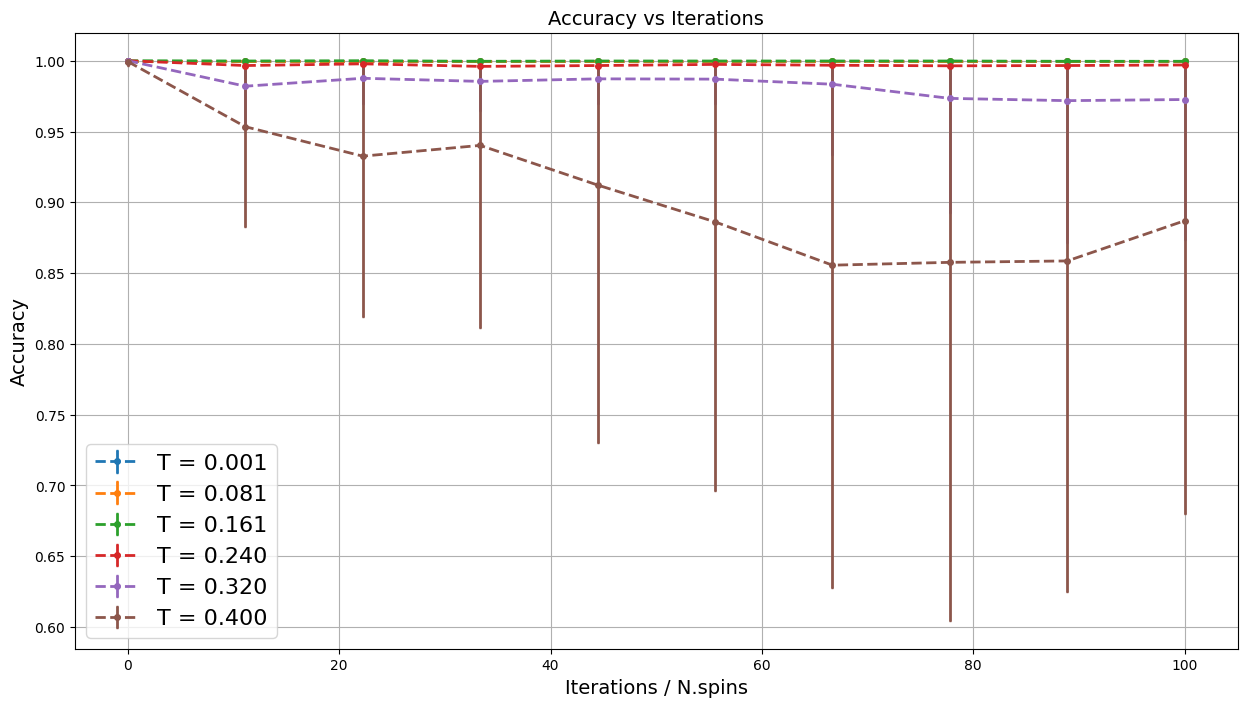

In [55]:
steps = np.linspace(1, 10000, 10, dtype='int')  #steps for the Metropolis algorithm
fractions = steps / (rows * columns)  #ratio between iterations and spins
T = np.linspace(0.001, 0.4, 6)  #range of temperatures to check

plt.figure(figsize=(15, 8))
runs = 100

for temperature in T:
    accuracy_list = []
    upper_errors = []
    lower_errors = []
    
    for step in steps:
        accuracy = []
        for _ in range(runs):
            i = select_pattern_2d(patterns)
            corrupted = pattern_corruption_2d(patterns[i], 0)
            retrieved = metropolis_2d(corrupted, J, temperature, step)
            accuracy.append(mattis_overlap_2d(patterns[i], retrieved))
            
        accuracy_mean = np.mean(accuracy)
        accuracy_std = np.std(accuracy)
        
        # Compute physically meaningful error bars
        upper_err = min(accuracy_std, 1 - accuracy_mean)
        lower_err = accuracy_std
        
        accuracy_list.append(accuracy_mean)
        upper_errors.append(upper_err)
        lower_errors.append(lower_err)
    
    # Plotting with asymmetric error bars
    plt.errorbar(fractions, np.array(accuracy_list), yerr=[lower_errors, upper_errors], marker='o', linestyle="--", 
                 markersize=4, linewidth=2, label=f"T = {temperature:.3f}", capsize=1)

plt.grid()
plt.title("Accuracy vs Iterations", fontsize=14)
plt.xlabel("Iterations / N.spins", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(prop={'size': 16}, loc='best')

So we see that appoximately for T $\le$ 0.3 (i. e. $\beta$ $\ge$ 3.3 ) the model is sufficiently stable for approximately an arbitrary number of iterations of the Metropolis algorithm.
For the further analysis we fix the temperature at T = 0.1 ($\beta$ = 10).

### Overlaps with other patterns

Using the Mattis overlap order parameter, we can analyze how overlaps behave in the problematic temperature and iteration ranges we identified. 

#### a)  Overlaps for high temperatures & appropriate number of iterations

In [56]:
#Check for overlaps
overlaps = []
T = 1.5 #fix t
steps = 100
n_chosen = select_pattern_2d(patterns) #choose a random pattern
retrieved = metropolis_2d(patterns[n_chosen],J,T,steps)
for pattern in patterns:
    overlap = mattis_overlap_2d(retrieved,pattern)
    overlaps.append(overlap)
overlaps = np.array(overlaps)

selected pattern number: 0, retrieved pattern number: 0, with accuracy: 0.76


Text(0, 0.5, 'Overlap Value')

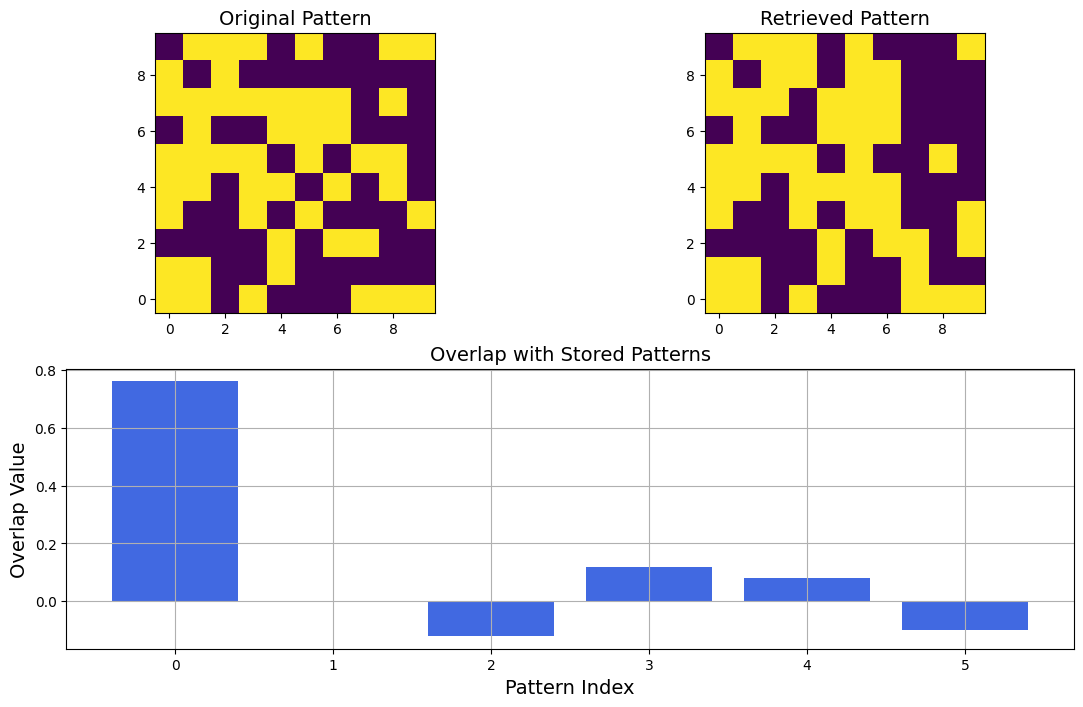

In [57]:
#visualization:

fig = plt.figure(figsize=(13, 8))
# Upper row: Original and Retrieved pattern
ax1 = plt.subplot2grid((2, 2), (0, 0))  
ax2 = plt.subplot2grid((2, 2), (0, 1))  
# Bottom row: Overlap plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)  

#print the accuracy of the retrieval
print(f"selected pattern number: {n_chosen}, retrieved pattern number: {np.argmax(overlaps)}, with accuracy: {overlaps[n_chosen]}")

#plot original and retrieved pattern
ax1.imshow(patterns[n_chosen], origin='lower')
ax1.set_title("Original Pattern", fontsize=14)

ax2.imshow(retrieved, origin='lower')
ax2.set_title("Retrieved Pattern", fontsize=14)

# Plot overlaps in the bottom subplot
ax3.grid()
ax3.bar(range(len(overlaps)), overlaps, color="royalblue")
ax3.set_title("Overlap with Stored Patterns", fontsize=14)
ax3.set_xlabel("Pattern Index", fontsize=14)
ax3.set_ylabel("Overlap Value", fontsize=14)

Now we can compute statistics on the system's ability to retrieve the correct pattern: we run 100 simulations of the previous process and we consider the retrieved pattern the one with the highest overlap value:

In [58]:
correct_retrieve = []
for _ in range(runs):
    overlaps = []
    i = select_pattern_2d(patterns)
    corrupted = pattern_corruption_2d(patterns[i],0) # zero corruption of the pattern
    retrieved = metropolis_2d(corrupted,J,T,steps)
    for pattern in patterns:
        overlap = mattis_overlap_2d(retrieved,pattern)
        overlaps.append(overlap)
    if (np.argmax(overlaps) == i):
        correct_retrieve.append(True)
    else:
        correct_retrieve.append(False)

correct_retrieve = np.array(correct_retrieve)
print("Fraction of correct retrieve:", np.mean(correct_retrieve))

Fraction of correct retrieve: 0.99


So, if we select a temperature above the range identified previously, the network can still retrieve the correct pattern in most cases, but with reduced accuracy. This loss in accuracy increases proportionally with temperature (as we have seen in the first plot).

In this regime, there is no significant overlap between the retrieved pattern and the other stored patterns, as confirmed by the "bar plot", which shows distinction in overlap values. This suggests that while retrieval is still possible at higher temperatures, the precision of the recalled pattern decreases due to increased randomness in spin updates.

#### b) Overlaps for high temperatures & high number of iterations

In [59]:
#Check for overlaps
overlaps = []
T = 1.5
steps = 1000 #add a factor 10 to the steps
n_chosen = select_pattern_2d(patterns) #choose a random pattern
retrieved = metropolis_2d(patterns[n_chosen],J,T,steps)
for pattern in patterns:
    overlap = mattis_overlap_2d(retrieved,pattern)
    overlaps.append(overlap)
overlaps = np.array(overlaps)

selected pattern number: 3, retrieved pattern number: 0, with accuracy: -0.16


Text(0, 0.5, 'Overlap Value')

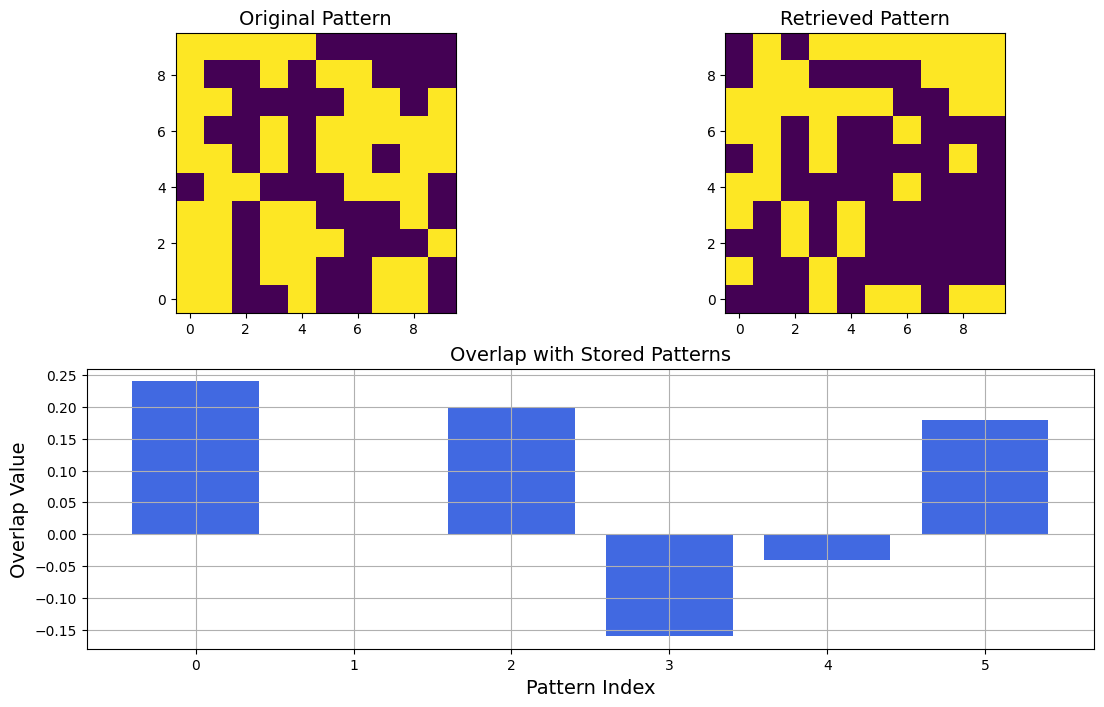

In [60]:
#visualization
fig = plt.figure(figsize=(13, 8))

# Upper row: Original and Retrieved pattern
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))

# Bottom row: Overlap plot
ax3 = plt.subplot2grid((2, 2), (1, 0),colspan = 2) 
#ax4 = plt.subplot2grid((2, 2), (1, 1))
print(f"selected pattern number: {n_chosen}, retrieved pattern number: {np.argmax(overlaps)}, with accuracy: {overlaps[n_chosen]}")

#plot original and retrieved pattern
ax1.imshow(patterns[n_chosen], origin='lower')
ax1.set_title("Original Pattern", fontsize=14)

ax2.imshow(retrieved, origin='lower')
ax2.set_title("Retrieved Pattern", fontsize=14)

# Plot overlaps in the bottom subplot
ax3.grid()
ax3.bar(range(len(overlaps)), overlaps, color="royalblue")
ax3.set_title("Overlap with Stored Patterns", fontsize=14)
ax3.set_xlabel("Pattern Index", fontsize=14)
ax3.set_ylabel("Overlap Value", fontsize=14)


As before we check the fraction of correct retrieved patterns: 

In [61]:
correct_retrieve = []
for _ in range(runs):
    overlaps = []
    i = select_pattern_2d(patterns)
    corrupted = pattern_corruption_2d(patterns[i],0) # zero corruption of the pattern
    retrieved = metropolis_2d(corrupted,J,T,steps)
    for pattern in patterns:
        overlap = mattis_overlap_2d(retrieved,pattern)
        overlaps.append(overlap)
    if (np.argmax(overlaps) == i):
        correct_retrieve.append(True)
    else:
        correct_retrieve.append(False)

correct_retrieve = np.array(correct_retrieve)
print("Fraction of correct retrieve:",np.mean(correct_retrieve))

Fraction of correct retrieve: 0.17


For excessive iterations at moderate-to-high temperatures the probability of random spin flips increases over time, causing the overlap to degrade as the system moves away from the stored pattern.

In the next section we will evaluate the network's ability to retrieve a stored pattern from a corrupted version by introducing some noise. This will help us understanding how well the system can retrieve a stored pattern and within what limits.

## 2) Analysis of retrieval ability

For the next steps, the function **"pattern_corruption"** flips randomly a fraction **q** of the spins in the pattern.
Here we can see an example of this procedure:

Accuracy of the retrieval: 1.00


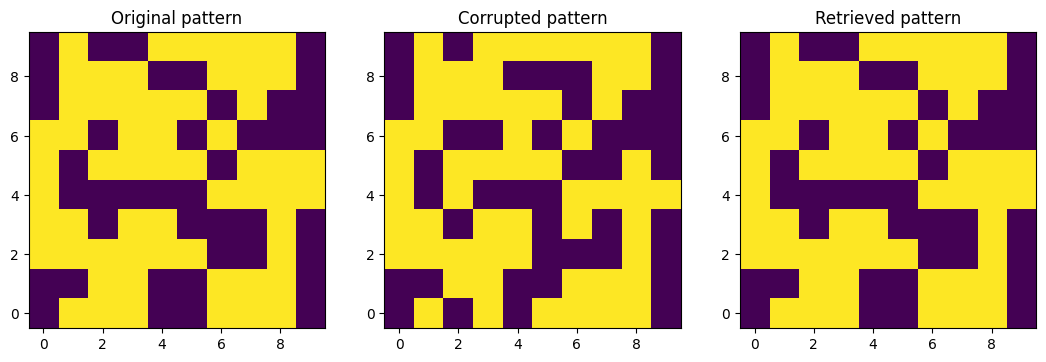

In [62]:
n_chosen = select_pattern_2d(patterns) #random select one pattern among the ones stored
q = 0.1 #fraction of spin flips
corrupted = pattern_corruption_2d(patterns[n_chosen],q) #corrupt it by flipping randomly the 10% of the spins

#we try to retrieve the the stored pattern using Metropolis algorithm:
T = 0.1
steps = 800
retrieved = metropolis_2d(corrupted,J,T,steps)
accuracy = mattis_overlap_2d(patterns[n_chosen],retrieved)

fig, ax = plt.subplots(1,3,figsize=(13,5))
ax[0].imshow(patterns[n_chosen], origin = 'lower')
ax[0].set_title('Original pattern')
ax[1].imshow(corrupted, origin = 'lower')
ax[1].set_title("Corrupted pattern")
ax[2].imshow(retrieved, origin = 'lower')
ax[2].set_title("Retrieved pattern")


print(f"Accuracy of the retrieval: {accuracy:.2f}")

As mentioned earlier, the stored patterns represent absolute (or relative) energy minima. We can observe how the energy of a pattern evolves with each iteration, gradually converging to the original pattern that existed before the corruption process. We can see this by applying a recursive procedure:

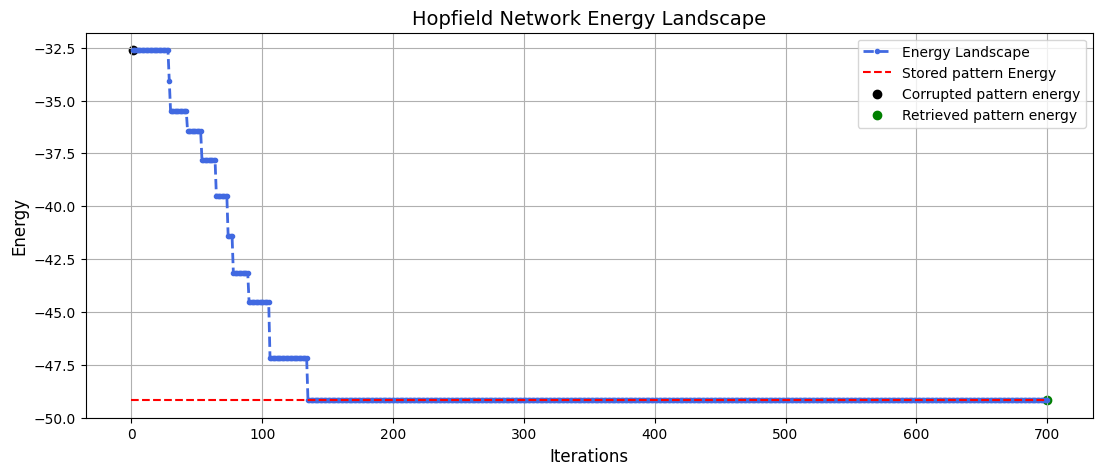

In [63]:
pattern_energy = compute_energy_2d(patterns[n_chosen], J)
energy_landscape = [] #save the energy after each iteration

for _ in range(700): 
    retrieved = metropolis_2d(corrupted, J, T, 1) #we perform only one iteration
    energy_landscape.append(compute_energy_2d(retrieved, J))
    corrupted = retrieved #update the corrupted pattern

iterations = np.linspace(1, 700, 700) #"x-axis" in the plot

# Plot energy landscape
#figure
plt.figure(figsize=(13, 5))
plt.grid()
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Energy", fontsize=12)
plt.title("Hopfield Network Energy Landscape", fontsize=14)

#data
plt.plot(iterations, energy_landscape, marker = 'o',linestyle="--", markersize = 3, label="Energy Landscape", 
         color="royalblue", linewidth=2)
plt.hlines(y=pattern_energy, xmin=0, xmax=700, colors="red", linestyle="--", label="Stored pattern Energy")
#Marking initial & final energy values
plt.scatter(1, energy_landscape[0], color='black', marker='o', label="Corrupted pattern energy")
plt.scatter(700, energy_landscape[-1], color='green', marker='o', label="Retrieved pattern energy")

plt.legend()



### Retrival ability varying the number of iterations

Now we check how "fast" (i.e. how many iterations) the network needs to reconstruct a corrupted version of a stored pattern:

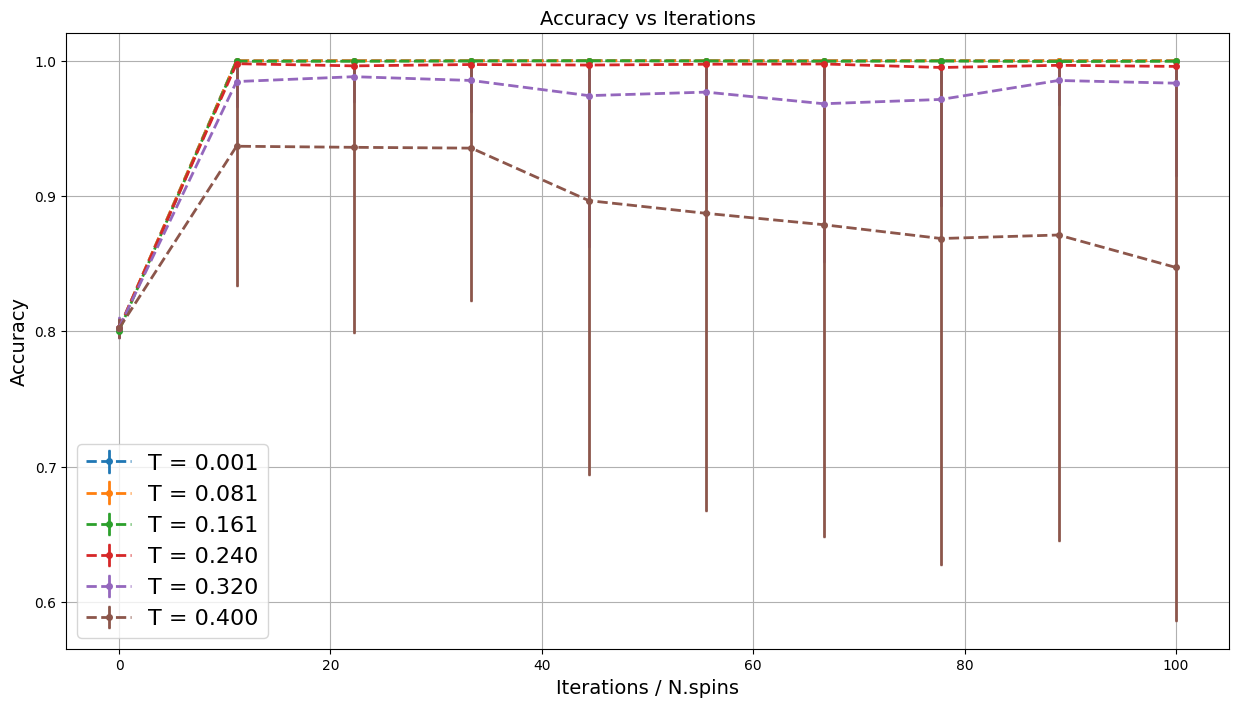

In [64]:
steps = np.linspace(1, 10000, 10, dtype='int')  #steps for the Metropolis algorithm
fractions = steps / (rows * columns)  #ratio between iterations and spins
T = np.linspace(0.001, 0.4, 6)  #range of temperatures to check

plt.figure(figsize=(15, 8))
for temperature in T:
    accuracy_list = []
    upper_errors = []
    lower_errors = []
    
    for step in steps:
        accuracy = []
        for _ in range(runs):
            i = select_pattern_2d(patterns)
            corrupted = pattern_corruption_2d(patterns[i], q)
            retrieved = metropolis_2d(corrupted, J, temperature, step)
            accuracy.append(mattis_overlap_2d(patterns[i], retrieved))
            
        accuracy_mean = np.mean(accuracy)
        accuracy_std = np.std(accuracy)
        
        # Compute physically meaningful error bars
        upper_err = min(accuracy_std, 1 - accuracy_mean)
        lower_err = accuracy_std
        
        accuracy_list.append(accuracy_mean)
        upper_errors.append(upper_err)
        lower_errors.append(lower_err)
    
    # Plotting with asymmetric error bars
    plt.errorbar(fractions, np.array(accuracy_list), yerr=[lower_errors, upper_errors], marker='o', linestyle="--", 
                 markersize=4, linewidth=2, label=f"T = {temperature:.3f}", capsize=1)

plt.grid()
plt.title("Accuracy vs Iterations", fontsize=14)
plt.xlabel("Iterations / N.spins", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(prop={'size': 16}, loc='best')

As we can see, within a "safe" temperature range and for the chosen percentage of spins flipped, convergence occurs after approximately ten times the number of spins involved. For instance, we can select 1000 iterations in the following.

### Retrieval ability varying q

<ErrorbarContainer object of 3 artists>

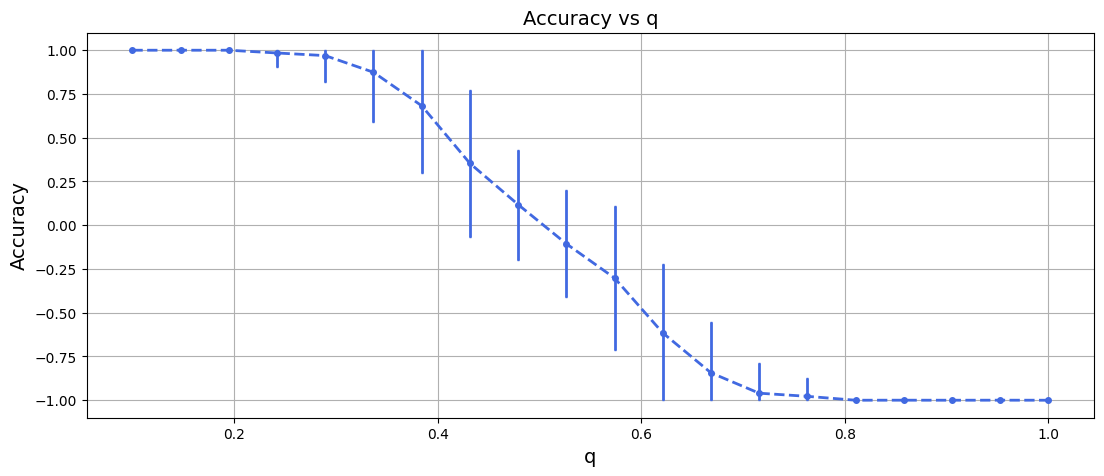

In [65]:
q_values = np.linspace(0.1,1,20) #different percentage of flips
steps = 1000 #steps for the Metropolis algorithm
T = 0.1
accuracy_list = [] 
upper_errors = []
lower_errors = []

for q in q_values:
    accuracy = []
    for _ in range(runs): #we compute the accuracy 150 times for each value of q and then compute the mean
        i = select_pattern_2d(patterns)
        corrupted = pattern_corruption_2d(patterns[i],q) # corrupt a spin with probability q
        retrieved = metropolis_2d(corrupted,J,T,steps)
        accuracy.append(mattis_overlap_2d(patterns[i],retrieved))
    accuracy = np.array(accuracy)
    accuracy_mean = np.mean(accuracy)
    accuracy_std = np.std(accuracy)
    
    # errors
    upper_err = min(accuracy_std, 1 - accuracy_mean)
    lower_err = min(accuracy_std, accuracy_mean + 1)
    
    accuracy_list.append(accuracy_mean)
    upper_errors.append(upper_err)
    lower_errors.append(lower_err)

#Plotting the results
plt.figure(figsize = (13,5))
plt.grid()
plt.title("Accuracy vs q", fontsize = 14)
plt.xlabel("q", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.errorbar(q_values, np.array(accuracy_list), yerr=[lower_errors, upper_errors], marker='o', linestyle="--", markersize=4, 
            color="royalblue", linewidth=2, label="Accuracy vs q", capsize=1)

From the plot we can recognize different behaviours:

- If the random flip probability is low (approximately q $\leq$ 0.3) the network can retrieve the stored pattern with sufficent accuracy (more than 80%).
- If q $\approx$ 0.5, the accuracy il close to zero: this means the network can't recall the original pattern and outputs a random sequence of spins.
- Increasing further the value of q, the network tends to retrieve the original pattern, but with all the spins flipped.

This last point makes sense from a statistical mechanics perspective: The Ising model has $Z^2$ simmetry, and changing the sign of all the spins gives the same energy value.

## Accuracy varying $\alpha$

We now want to check how the retrieval capacity of the network varies basing on the number of stored patterns. Here $\alpha$ is the ratio between the number of stored patterns and the number N of spins. We will first check the retrieval success rate — how often the network retrieves the correct pattern - and then how precise is that retrieval:

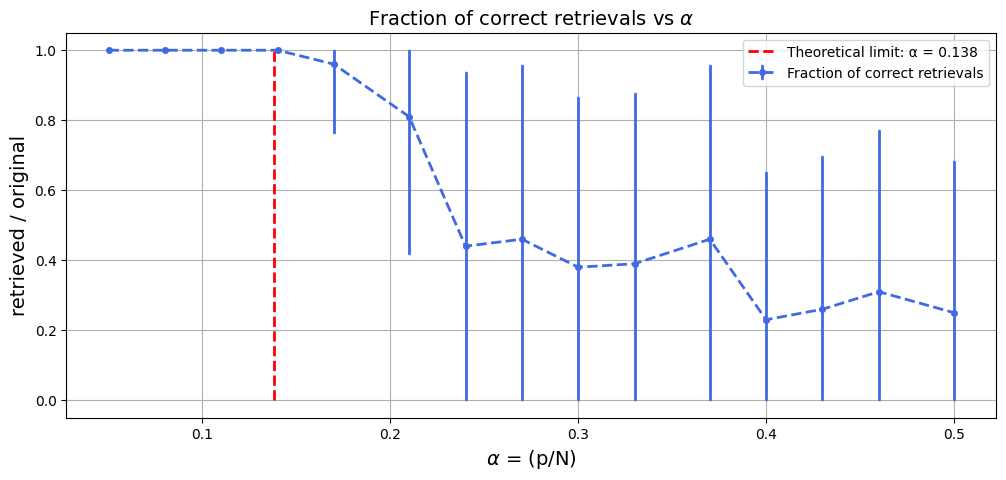

In [66]:
P = np.linspace(5, 50, 15, dtype=int)  # Array of pattern counts
rows, columns = 10, 10  # Number of spins in a pattern
T = 0.1
steps = 1000
alphas = []
patterns = []  # This will store patterns incrementally

#list for quantities we are interested in

accuracy_list = [] #precision of a retrieval
acc_upper_errors = []
acc_lower_errors = []

check_correctness = [] #fraction of correct retrievals
check_upper_errors = []
check_lower_errors = []


for p in P:
    np.random.seed(1234)  # Reset seed so old patterns are regenerated exactly
    patterns = create_patterns_2d(rows, columns, p)  
    J = compute_weights_2d(patterns)  
    accuracy = []
    correctness = []
    
    for _ in range(runs):  
        i = select_pattern_2d(patterns)
        corrupted = pattern_corruption_2d(patterns[i], 0.1)  # Corrupt 10% of spins
        retrieved = metropolis_2d(corrupted, J, T, steps)
        accuracy.append(mattis_overlap_2d(patterns[i], retrieved))
        overlaps_run = [] #list to store the overlaps
        for pattern in patterns:
            overlap = mattis_overlap_2d(retrieved, pattern)
            overlaps_run.append(overlap)  # Append each overlap to the list
        if np.argmax(overlaps_run) == i:  #if the index with highest overlap is equal to the chosen pattern 
            correctness.append(1.0)       #correct retrieval
        else:
            correctness.append(0.0)
        
        
    accuracy = np.array(accuracy)
    accuracy_mean = np.mean(accuracy)
    accuracy_std = np.std(accuracy)
    
    correctness = np.array(correctness)
    check_correctness_mean = np.mean(correctness)
    check_correctness_std = np.std(correctness)
    
    # errors
    acc_upper_err = min(accuracy_std, 1 - accuracy_mean)
    acc_lower_err = accuracy_std
    check_upper_err = min(check_correctness_std, 1 - check_correctness_mean)
    check_lower_err = min(check_correctness_std, check_correctness_mean)
    
    #append to lists
    accuracy_list.append(accuracy_mean)
    acc_upper_errors.append(acc_upper_err)
    acc_lower_errors.append(acc_lower_err)
    
    check_correctness.append(check_correctness_mean)
    check_upper_errors.append(check_upper_err)
    check_lower_errors.append(check_lower_err)
    
    alphas.append(p / (rows * columns))  # Compute α = p/N

# Plot results
plt.figure(figsize=(12, 5))
plt.grid()
plt.title(r"Fraction of correct retrievals vs $\alpha$", fontsize=14)
plt.xlabel(r"$\alpha$ = (p/N)", fontsize=14)
plt.ylabel("retrieved / original", fontsize=14)

plt.errorbar(alphas, np.array(check_correctness), yerr=[check_lower_errors, check_upper_errors], marker='o', linestyle="--", markersize=4, 
            color="royalblue", linewidth=2, label="Fraction of correct retrievals", capsize=1)
plt.vlines(x=0.138, ymin=0.0, ymax=1, linestyle="--", color="red", label="Theoretical limit: α = 0.138", linewidth=2)

plt.legend(loc="best")

We have found that we have a sufficient good retrieval for values of $\alpha$ < 0.20. Now we can make a more accurate scan, plotting how precise is the retrieval of the network in that region of $\alpha$:

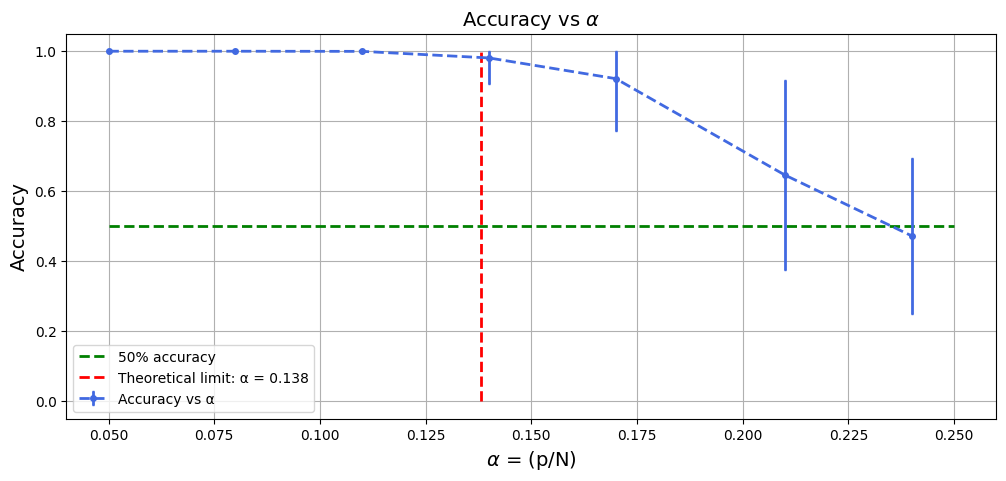

In [67]:
plt.figure(figsize=(12, 5))
plt.grid()
plt.title(r"Accuracy vs $\alpha$", fontsize=14)
plt.xlabel(r"$\alpha$ = (p/N)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

#transformed to array to create a mask
alphas = np.array(alphas) 
acc_lower_errors = np.array(acc_lower_errors)
acc_upper_errors = np.array(acc_upper_errors)

mask = alphas < 0.25
plt.hlines(y=0.5, xmin=alphas[0], xmax=0.25, color="green", linewidth=2, linestyle="--", label = '50% accuracy')
plt.vlines(x=0.138, ymin=0.0, ymax=1, linestyle="--", color="red", label="Theoretical limit: α = 0.138", linewidth=2)
plt.errorbar(alphas[mask], np.array(accuracy_list)[mask], yerr=[acc_lower_errors[mask], acc_upper_errors[mask]], marker='o', linestyle="--", markersize=4, 
            color="royalblue", linewidth=2, label="Accuracy vs α", capsize=1)

plt.legend(loc="best")

As we can see, in this particular case, there is good agreement with the theoretical result ($\alpha = 0.138$) for a perfect retrieval. However, it is important to note that the retrieval capacity of a Hopfield network also strongly depends on the nature and correlations of the stored patterns. Due to this, in some cases, the network’s retrieval performance may be better or worse than the theoretical prediction.

### Overlaps for different values of $\alpha$

We can check also in this situation the overlap between the retrieved pattern and the stored ones for $\alpha = 0.1$ and $\alpha = 0.4$:

For α = 0.1: selected pattern number: 6
For α = 0.4: selected pattern number: 39


For α = 0.1: retrieved pattern number: 6
For α = 0.4: retrieved pattern number: 17


Text(0, 0.5, 'Overlap')

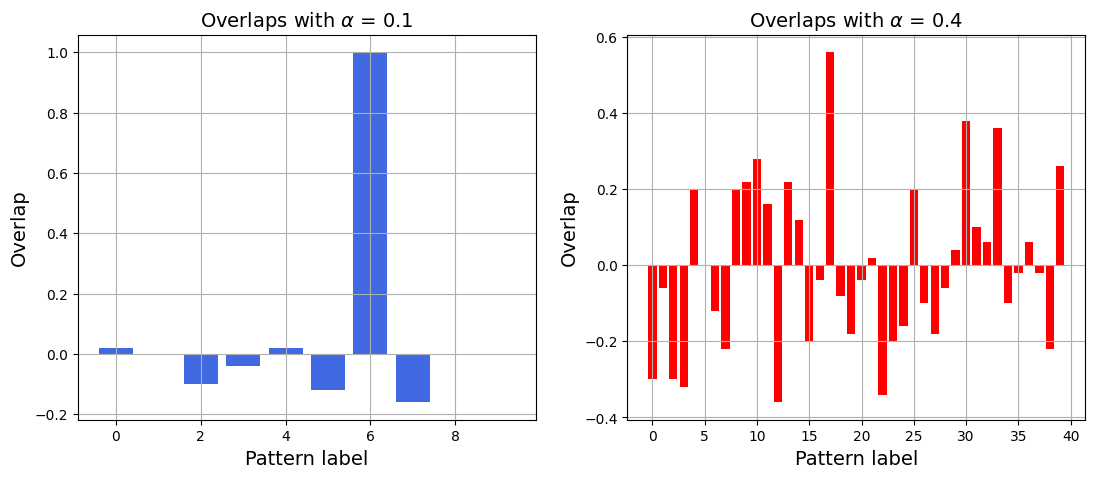

In [68]:
rows, columns = 10, 10
alphas = [0.1,0.4]
overlap_01 = []
overlap_04 = []
T = 0.1
steps = 1000

for alpha in alphas: 
    N_patterns = int(alpha * rows * columns)
    patterns = create_patterns_2d(rows,columns,N_patterns)
    J = compute_weights_2d(patterns)
    n = select_pattern_2d(patterns) #choose a random pattern
    retrieved = metropolis_2d(patterns[n],J,T,steps)
    for pattern in patterns:
        overlap = mattis_overlap_2d(retrieved,pattern)
        if (alpha == 0.1):
            overlap_01.append(overlap)
        else: 
            overlap_04.append(overlap)
    print(fr"For α = {alpha}: selected pattern number: {n}")
print("\n")
print(fr"For α = {alphas[0]}: retrieved pattern number: {np.argmax(overlap_01)}")
print(fr"For α = {alphas[1]}: retrieved pattern number: {np.argmax(overlap_04)}")


#visualization:
fig, ax = plt.subplots(1,2,figsize = (13,5))
#alpha = 0.1
ax[0].grid()
ax[0].bar(range(len(overlap_01)), overlap_01, color="royalblue")
ax[0].set_title(r"Overlaps with $\alpha$ = 0.1", fontsize = 14)
ax[0].set_xlabel("Pattern label", fontsize = 14)
ax[0].set_ylabel("Overlap", fontsize = 14)
#alpha = 0.4
ax[1].grid()
ax[1].bar(range(len(overlap_04)), overlap_04, color="red")
ax[1].set_title(r"Overlaps with $\alpha$ = 0.4", fontsize = 14)
ax[1].set_xlabel("Pattern label", fontsize = 14)
ax[1].set_ylabel("Overlap", fontsize = 14)

As expected, the overlap between patterns increases as $\alpha$ increases. While the network may still be able to retrieve the correct pattern in some cases as we have seen in the previous plots, it does so with a significant loss of information (i.e. incorrect spin flips), likely caused by similarities with other stored patterns.

## Time complexity

The last part on this section is about time complexity of the Monte Carlo algorithm for retrieval process:

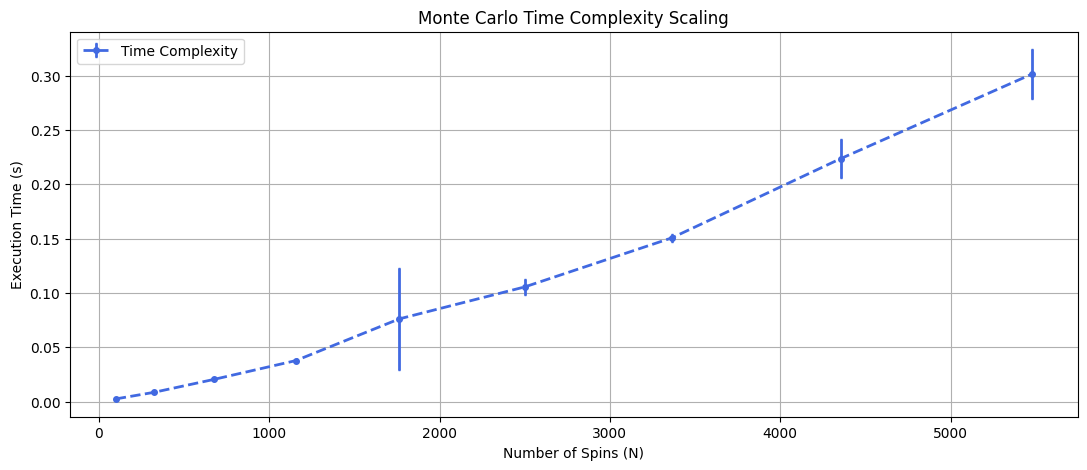

In [69]:
import time
T = 0.1  
N_values = np.arange(10, 80, 8)  # Different spin system sizes
N_patterns = 10
times = []
error_times = []
runs = 50
for N in N_values:
    appending_time = []
    for _ in range(runs):
        patterns = create_patterns_2d(N, N, N_patterns)  # Generate patterns
        weights = compute_weights_2d(patterns)  # Compute weights
        i = select_pattern_2d(patterns)  # Select a pattern
        corrupted = pattern_corruption_2d(patterns[i], q=0.1)  # Corrupt it

        steps = 5 * N * N  # Interactions are always 5 * N**2

        start_time = time.time()
        metropolis_2d(corrupted, weights, T, steps)  # Run Monte Carlo
        appending_time.append(time.time() - start_time)
    appending_time = np.array(appending_time)
    times.append(np.mean(appending_time))
    error_times.append(np.std(appending_time))

plt.figure(figsize=(13,5))
plt.grid()
plt.errorbar(N_values**2, times, yerr=error_times, linestyle="--", color='royalblue', marker = 'o', markersize = 4, capsize = 1, 
             linewidth=2, label='Time Complexity')
plt.xlabel('Number of Spins (N)')
plt.ylabel('Execution Time (s)')
plt.title('Monte Carlo Time Complexity Scaling')
plt.legend()

We see that this algorithm is approximately O(N).

# Section 3: Modern Hopfield Network

This model is a generalization of the original Hopfield network and first appeared in an article by Krotov and Hofield in 2016 [3.1]. 
It considers a new energy function defined as:
\begin{equation*}
  E (\sigma) = - \sum_{\mu = 1}^K F \left( \xi_\mu \cdot \sigma \right)
\end{equation*}
where $\{\xi_{\mu}\}_{\mu=1}^K$ are the $K$ different patterns stored in memory and $\sigma$ is the new pattern we want to know the energy of. 
We implemented three different types of function:
- polynomial function of degree $n$:
\begin{equation*}
  F(x) = x^n
\end{equation*}
- rectified polynomial function of degree $n$:
\begin{equation*}
  F(x) = \left\{
  \begin{array}{lr}
    x^n & x \geq 0 \\
    0 & x < 0
  \end{array}
  \right.
\end{equation*}
- exponential function (this one was proposed in [3.2] as the limit $n \to \infty$ of the polynomial one):
\begin{equation*}
  F(x) = e^{x}
\end{equation*}

We can see how, if we consider $F(x)$ as a polynomial of degree $n=2$, the model is equivalent to the original Hopfield network described above.

A new update function was also devised:

\begin{equation*} 
  \sigma^{(t+1)}_i = \mathrm{sign} \left[ \sum_{\mu=1}^K \left( F \left( \xi_i^{\mu} + \sum_{j \neq i} \xi_j^{\mu} \sigma_j^{(t)} \right) 
  - F \left( - \xi_i^{\mu} + \sum_{j \neq i} \xi_j^{\mu} \sigma_j^{(t)} \right) \right) \right]
\end{equation*}

[3.1] D. Krotov and J. J. Hopfield, "Dense associative memory for pattern recognition" in *Proc. Adv. Neural Inf. Process. Syst.*, vol. 29, 2016, pp. 1172–1180.

[3.2] Demircigil, Mete; et al. (2017). "On a model of associative memory with huge storage capacity" in *Journal of Statistical Physics*. 168 (2): 288–299.

In [117]:
class modern_hopfield():
  
  def __init__(self, pattern_lenght: int, func_type: str = "Polyn", poly_deg: int = 3):
    """
    Args:
        pattern_lenght (int): Lenght of each pattern stored in the network 
        func_type (str): Type of function used to evaluate the energy of a single pattern. Possible options are "Polyn", "RePn", "Exp" \n
        poly_deg (int): Degree of the polynomial function used in the evaluation of the energy
    """
    self.pattern_lenght = pattern_lenght
    self.memory_matrix = np.zeros(shape=(1,self.pattern_lenght))
    self.func_type = func_type
    self.deg = poly_deg
    return
  
  def add_patterns(self, p: np.ndarray):
    """
    Args:
        p (ndarray): pattern to add to memory
    """
    if self.memory_matrix[0,0]==0:
      self.memory_matrix = p
    else:
      self.memory_matrix = np.vstack((self.memory_matrix, p))
    return

  def retrieve_pattern(self, p: np.ndarray, epochs: int):
    """
    Args:
        p (ndarray): input pattern  \n
        epochs (int): maximum number of iterations \n
    performs the update rule up to `epochs` times, trying to match the input pattern `p` to a pattern stored in memory     
    """
    sigma = p.copy()
    for epoch in range(epochs):
      sigma = self._update_rule(sigma)
    return sigma

  def energy(self, sigma: np.ndarray):
    """
    Args:
        sigma (ndarray):
    Computes the energy of the pattern `sigma`
    """
    return - np.sum(self._F(np.dot(self.memory_matrix, sigma)))

  def _update_rule(self, sigma: np.ndarray):
    """
    Args:
        sigma (ndarray): vector containing the values of the network's neurons at time t. \n 
    Returns the values of the network's neurons at time t+1 
    """
    s = 0
    for xi in self.memory_matrix:
      s += self._F(xi + np.dot(xi, sigma) - np.multiply(xi, sigma)) - self._F(-xi + np.dot(xi, sigma) - np.multiply(xi, sigma))
    return np.sign(s)

  def _F(self, x: np.ndarray):
    """
    Different types of function:
    - `Polyn`: polynomial function of degree n
    - `RePn`: rectified polynomial function of degree n
    - `Exp`: exponential function
    """
    match self.func_type:
      case "Polyn":
        return x**self.deg
      case "RePn":
        return np.where(x > 0, x**self.deg, 0)
      case "Exp":
        return np.exp(x)
      

## Number of maximum patterns retrievable

As stated in [3.1], the maximum number of patterns this type of network is able to recover without error is:
\begin{equation*}
  K_{\text{no errors}}^{\text{max}} \approx \frac{1}{2 (2 n - 3) !!} \frac{N^{n-1}}{\ln N}
\end{equation*}
where $N$ is the number of neurons. 

We will now test this finding with our model.

In [118]:
def generate_patterns(pattern_lenght: int, N: int, c: float = 0.5):
  """
  Args:
    pattern_lenght (int): \n
    N (int): Number of patterns generated \n
    c (float): Probability of each element of having value -1 \n
  Returns:
    patterns (ndarray): Array of shape (`N`, `pattern_lenght`) containing in each of its rows a different casual pattern 
  """
  try:
    assert (c >= 0) and (c <= 1)
  except:
    print("q must be in the range [0,1]")
    return
  return np.random.choice([-1,1], size=(N,pattern_lenght), p=[c, 1-c])

In [119]:
def corrupt_patterns(patterns: np.ndarray, q: float = 0.1):
  """
  Args:
    patterns (ndarray):
    q (float): probability of each spin to change value
  Returns:
    corrupted_patterns (ndarray): 
  """
  try:
    assert q >= 0 and q <= 1
  except:
    print("q must have a value between 0 and 1 (included)")
    return
  
  corrupted = patterns.copy()
  choice = np.random.choice([0,1], size=corrupted.shape, p=[1-q, q])
  corrupted = np.where(choice == 0, corrupted, -corrupted)
  """
  for p in corrupted:
    choice = np.random.choice([0,1], size=p.shape, p=[1-q, q])
    p[:] = np.where(choice == 0, p, -p)
  """
  return corrupted


In [120]:
def _double_factorial(N: int):
  if N > 0:
    return N * _double_factorial(N - 2)
  else:
    return 1

def maximum_recall(pattern_lenght: int, degree: int):
  """
  Returns the expected number of patterns a modern hopfield network of size `pattern_lenght` 
  whose energy functions is a polynomial of order `degree` can recall
  """
  return pattern_lenght**(degree - 1) / (2 * _double_factorial(2 * degree - 3) * np.log(pattern_lenght)) 

In [121]:
# hyperparameters of the analysis
pattern_lenght = 25
n_patterns = [1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
epochs = 10
max_order = 5
test_size = 20

In [122]:
# we first compute the expected value of k_max given by the formula above 
expected_kmax = []
for d in range(2, max_order+1):
  expected_kmax.append(maximum_recall(pattern_lenght, d))
expected_kmax = np.array(expected_kmax)
print(expected_kmax)

[  3.88334334  32.36119451 161.80597254 577.87847336]


In [123]:
# we now compute the accuracy of our model in the retrieving task

results = []
for n in range(2, max_order+1):
  accuracy = []
  for L in n_patterns:
    # generating L patterns and saving them to memeory 
    patterns = generate_patterns(pattern_lenght=pattern_lenght, N=L)
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type="Polyn", poly_deg=n)
    model.add_patterns(patterns)

    # we now select a subset of patterns to test our model
    perm = np.random.permutation(patterns.shape[0])
    ts = np.minimum(test_size, L)
    test_patterns = patterns[perm, :][:ts,:]
    
    # computing the accuracy
    acc = 0
    for i, p in enumerate(test_patterns):
      r = model.retrieve_pattern(p=p, epochs=epochs)
      if np.array_equal(test_patterns[i,:], r):
        acc += 1
    acc /= ts
    accuracy.append(acc)
  results.append(accuracy)

results = np.array(results)

print(results)

[[1.   0.1  0.05 0.   0.   0.   0.   0.   0.   0.  ]
 [1.   1.   1.   0.65 0.1  0.   0.   0.   0.   0.  ]
 [1.   1.   1.   1.   0.95 0.7  0.1  0.05 0.   0.  ]
 [1.   1.   1.   1.   1.   1.   0.75 0.65 0.15 0.05]]


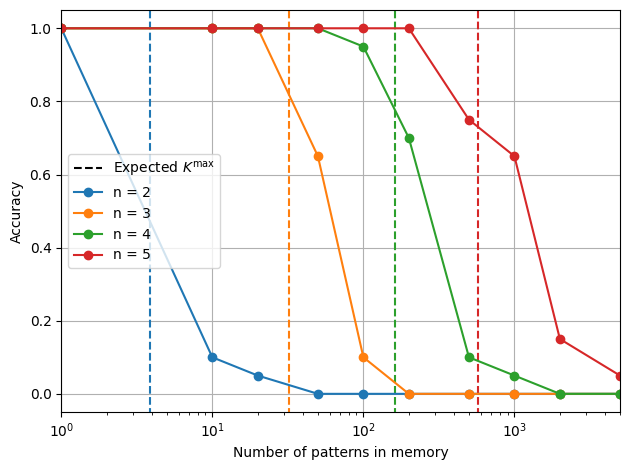

In [124]:
# let's visualize it
fig, ax = plt.subplots()

# plotting of the accuracies
for d in range(max_order - 1):
  ax.errorbar(n_patterns, results[d,:], fmt="o-", alpha=1, label=f"n = {d+2}", color=colormap.colors[d])

# plotting of the expected k_max
for i in range(expected_kmax.shape[0]):
  ax.vlines(expected_kmax[i], ymin=-1, ymax=2, linestyles="--", colors=colormap.colors[i])


# this is just for legend purposes
ax.vlines(0, ymin=0, ymax=0, label=r"Expected $K^{\text{max}}$", linestyles="--", colors='black')


ax.set_xscale('log')
ax.set_xlim(n_patterns[0], n_patterns[-1])
ax.set_ylim(-0.05, 1.05)

ax.set_xlabel("Number of patterns in memory")
ax.set_ylabel("Accuracy")

ax.legend()
ax.grid()

fig.tight_layout()

We can see how our model capacity increases as the degree of the polynomial increases and it reflects the estimation given in [3.1].

## Retrieval of corrupted patterns
We now want to test the accuracy of our model in retrieving patterns from memory that have been corrupted.
The corruption process utilized consists in flipping any neuron of a pattern with a certain probability $q$. 
Given the nature of our neurons (either having value +1 or -1) we have that the maximum amount of corruption (basically complete randomness) will be reached for $q \sim 0.5$, and we can see that corrupting a patter with $q=1$ will give us the "negative" of the pattern (every spin has its sign changed).

Let's start by testing how changing the function type affects the model's ability to retrieve patterns.

In [125]:
# hyperparameters of the analysis
pattern_lenght = 100
n_patterns = 100
func_type = ["Polyn", "RePn", "Exp"]
poly_deg = 5

epochs = 10
test_size = 20
n_trials = 10
corruption_steps = 11

In [126]:
def corruption_func_type_analysis(func_type: str):
  """
  `func_type`: function type to initialize the model \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for i in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_deg=poly_deg)
    patterns = generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = corrupt_patterns(patterns=test_patterns, q=q)

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [127]:
# multithreading to speed up the process
pool = Pool(len(func_type))
results = pool.map(corruption_func_type_analysis, func_type)

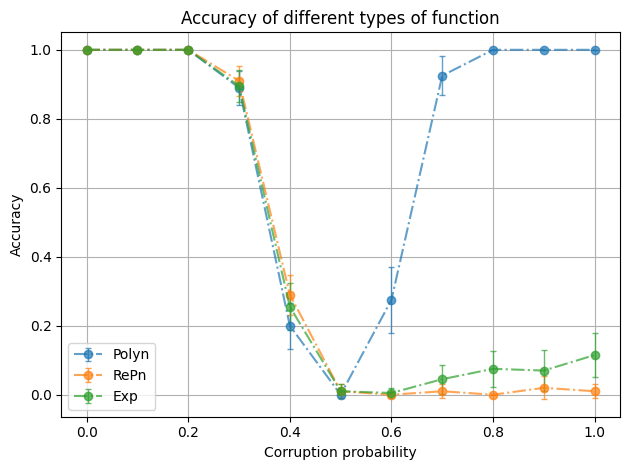

In [128]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=func_type[i],
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of different types of function")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()

We can see how the three different functions perform similarly for $q \leq 0.5$. However for $q > 0.5$ the polynomial one greatly outperforms the others as it is able to restore "negative" patterns back to their original form.
From now on we will use this function unless stated otherwise.

Another parameter to test is the degree of the polynomial.

In [129]:
# hyperparameters of the analysis
pattern_lenght = 100
n_patterns = 100
func_type = "Polyn"
poly_deg = [3, 4, 5, 6, 7, 8, 9]

epochs = 10
test_size = 20
n_trials = 10
corruption_steps = 11

In [130]:
def corruption_degree_analysis(poly_deg: int):
  """
  `epochs`: number of times the update function is used \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for i in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_deg=poly_deg)
    patterns = generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = corrupt_patterns(patterns=test_patterns, q=q)

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [131]:
# multithreading to speed up the process
pool = Pool(len(poly_deg))
results = pool.map(corruption_degree_analysis, poly_deg)

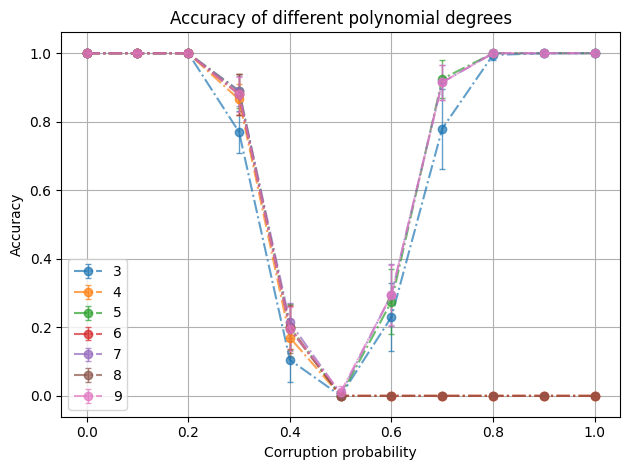

In [132]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=poly_deg[i],
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of different polynomial degrees")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()

We can observe how the best performance is obtained for $n \geq 5$ odd. For $n$ even the model isn't able to correcly identify the "negative" of a pattern.

We now want to test the ideal number of iterations that the retrieval algorithm should use to obtain the best performance. 

In [133]:
# hyperparameters of the analysis
pattern_lenght = 100
n_patterns = 100
func_type = "Polyn"
poly_deg = 5

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_size = 20
n_trials = 10
corruption_steps = 11

In [134]:
def corruption_epochs_analysis(epochs: int):
  """
  `epochs`: number of times the update function is used \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for i in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_deg=poly_deg)
    patterns = generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = corrupt_patterns(patterns=test_patterns, q=q)

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [135]:
results = []
for e in epochs:
  results.append(corruption_epochs_analysis(e))

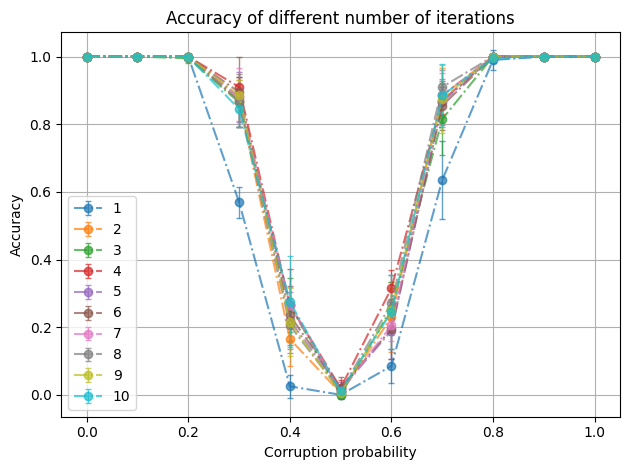

In [ ]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=f"{epochs[i]}",
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of different numbers of iterations")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()

As we can see it is convenient to run the retrieval algorithm for at least 2 iterations, as the performance greatly increases with respect to a single one.

Lastly we want to observe how the number of patterns stored influences the retrieval accuracy.

In [137]:
# hyperparameters of the analysis
pattern_lenght = 25
n_patterns = [10, 50, 100, 500, 1000]
func_type = "Polyn"
poly_deg = 5

epochs = 10
test_size = 20
n_trials = 10
corruption_steps = 11

In [138]:
def corruption_n_patterns_analysis(n_patterns: int):
  """
  `n_patterns`: number of patterns generated \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for _ in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_deg=poly_deg)
    patterns = generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = corrupt_patterns(patterns=test_patterns, q=q,)

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [139]:
# multithreading to speed up the process
pool = Pool(len(n_patterns))
results = pool.map(corruption_n_patterns_analysis, n_patterns)

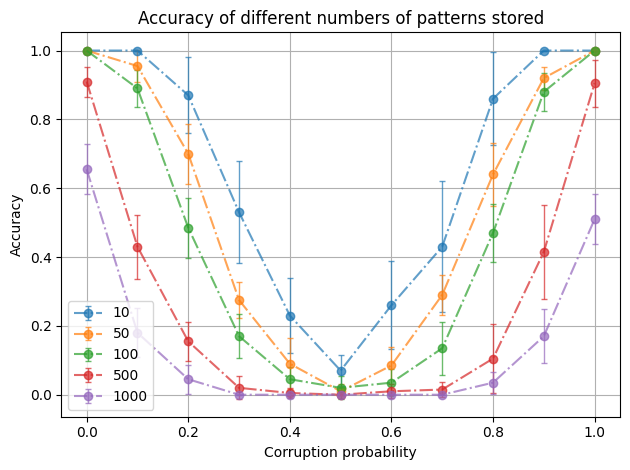

In [140]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=f"{n_patterns[i]}",
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of different numbers of patterns stored")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()


As expected, an higher number of patterns stored in memory results in overall worse perfomances over the whole range of $q$.

## Patterns with imbalance in the spins' contentrations

Up until now we have considered patterns where the concentrations of spins were pretty much equal. We want to test how the retrieval ability of the model is affected by an imbalance in the concentrations.

In [141]:
# hyperparameters of the analysis
pattern_lenght = 25
n_patterns = [1, 10, 20, 50, 100, 200, 500, 1000]
func_type = "Polyn"
poly_deg = 5

epochs = 10
test_size = 20
n_trials = 10
c_steps = 11

In [142]:
def imbalance_n_patterns_analysis(c: float):
  """
  Args:
    c (float): Probability of a spin to have value -1
  """

  accuracy = []
  for _ in range(n_trials):
    correcly_identified = []
    for n_p in n_patterns:
      # generating the patterns
      model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_deg=poly_deg)
      patterns = generate_patterns(pattern_lenght=pattern_lenght, N=n_p, c=c)
      model.add_patterns(patterns)
  
      # selecting the test set
      ts = np.minimum(n_p, test_size)
      perm = np.random.permutation(n_p)
      test_patterns = patterns[perm, :][:ts,:]

      # computing accuracies
      c_id = 0
      for i, t in enumerate(test_patterns):
        r = model.retrieve_pattern(t, epochs=epochs)
        if np.array_equal(test_patterns[i], r):
          c_id += 1
      correcly_identified.append(c_id / ts)
    accuracy.append(np.array(correcly_identified))
  return np.array(accuracy)          

In [143]:
# multithreading
n1 = 6
n2 = c_steps - n1
c = np.linspace(0, 1, c_steps)
pool = Pool(n1)
results = pool.map(imbalance_n_patterns_analysis, c[:n1])
pool = Pool(n2)
results.extend(pool.map(imbalance_n_patterns_analysis, c[n1:]))

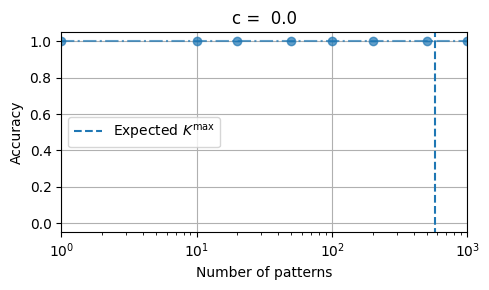

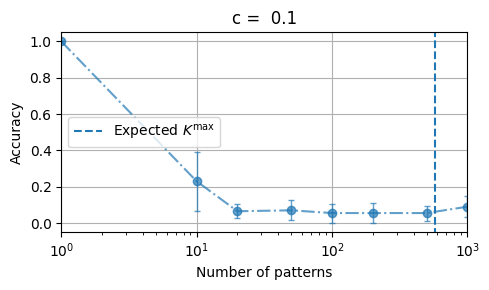

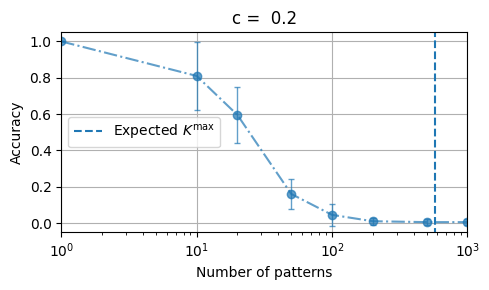

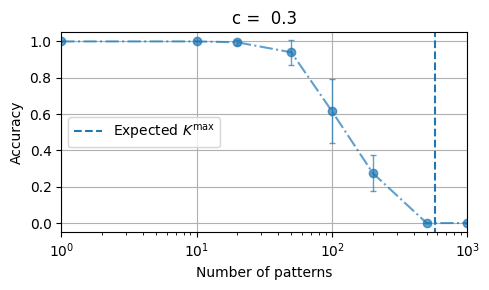

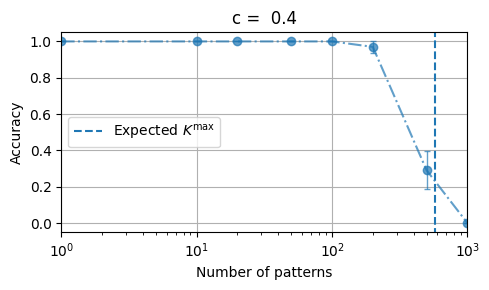

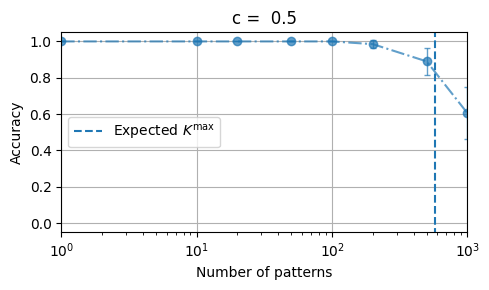

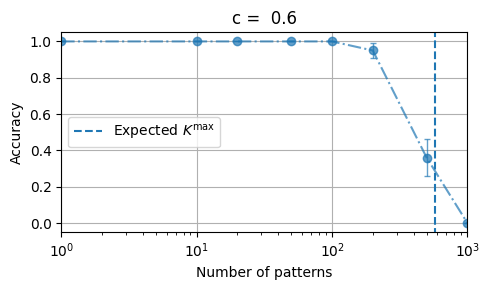

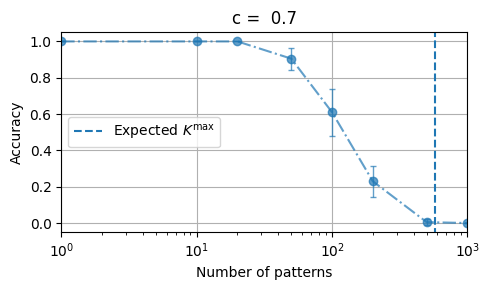

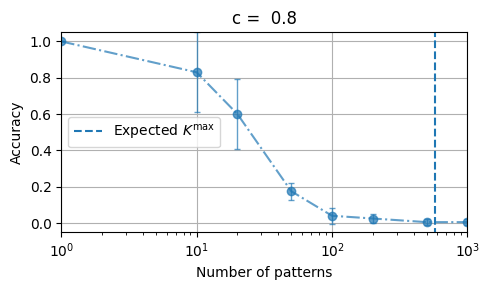

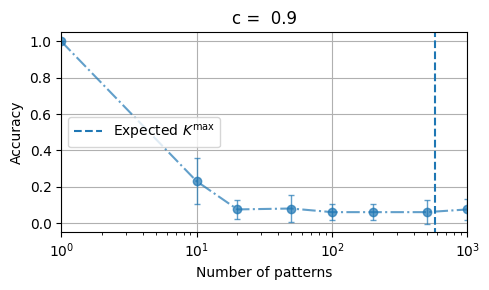

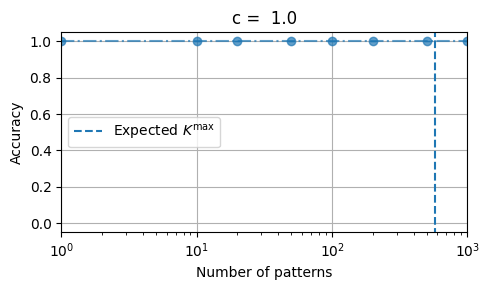

In [144]:
# plotting the results

for i, r in enumerate(results):
  fig, ax = plt.subplots(figsize=(5,3))
  
  ax.errorbar(n_patterns, np.mean(r, axis=0), yerr=np.std(r, axis=0),
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1)
  
  expected_kmax = maximum_recall(pattern_lenght=pattern_lenght, degree=poly_deg)
  ax.vlines(expected_kmax, ymin=-1, ymax=2, label=r"Expected $K^{\text{max}}$", linestyles="--")
  
  ax.legend(loc='center left')
  ax.set_ylim(-0.05, 1.05)
  ax.set_xlim(n_patterns[0], n_patterns[-1])
  ax.set_xlabel("Number of patterns")
  ax.set_ylabel("Accuracy")
  ax.set_title(f"c = {c[i]: .1f}")
  ax.set_xscale('log')
  ax.grid()
  fig.tight_layout()

Without considering the banal cases $c = 0$ and $c = 1$ (which correspond to the cases where all spins have value -1 or +1 respectively), we can see that the higher the distance from the balanced case ($c = 0.5$), the more reduced is the storage capacity of the model.

# Section 4: Applying the Hopfield Network to the MNIST dataset

In this section, we aim to evaluate the performance of the three Hopfield network implementations using a real-world dataset: the MNIST dataset.
This dataset consists of 28x28 pixel grayscale images of handwritten digits (ranging from 0 to 9) along with their corresponding labels.

Our objective is to determine which implementation performs best when applied to real data, moving beyond the synthetic, randomly generated patterns where all three models have shown successful retrieval.

To conduct this analysis, we will first import the dataset and select a subset of digits to store in each model. We will then corrupt the images by masking half of the spins containing relevant information to assess the network's ability to accurately reconstruct the original patterns. This process will allow us to compare the performance of the three implementations and identify which one is most effective in handling real-world data.

First of all, we need to load the dataset as a Pandas DataFrame. We have chosen to use the test set, as it contains fewer samples while still providing a sufficient number for our analysis. This choice is motivated by the fact that the Hopfield model has a limited capacity for storing patterns so we do not need many of them.

``` 
!wget -L -o ~/Downloads/mnist-dataset.zip https://www.kaggle.com/api/v1/datasets/download/hojjatk/mnist-dataset
```
To run this part of the project use the above command to download the mnist dataset and unzip the file in the ```./data/``` directory

In [98]:
# Load the dataset
df = pd.read_csv("data/mnist_test.csv")

# Check the shapes
print("Train shape:", df.shape)
print(df.head())

Train shape: (10000, 785)
   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      7    0    0    0    0    0    0    0    0    0  ...      0      0   
1      2    0    0    0    0    0    0    0    0    0  ...      0      0   
2      1    0    0    0    0    0    0    0    0    0  ...      0      0   
3      0    0    0    0    0    0    0    0    0    0  ...      0      0   
4      4    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


The dataset is composed of 785 columns. The first one contains the label, i.e, the value of the digit, while the other 784 columns represent each pixel of the actual image (28x28).
So, we have to separate data in features and labels matrices.

In [99]:
# Divide features and labels
label = df["label"].values
features = df.drop("label", axis=1).values

print(features.shape)

(10000, 784)


### Data preprocessing

Now we will define some helper functions allowing us to simplify the analysis and the choice of each pattern.

#### Helper functions

In [100]:
def binarize_image(img, threshold=0.35):
    """
    Put all the values to -1 or +1 according to the spin

    images: data to be binarized
    threshold: 127 because the greyscale is from 0 to 255
    """
    
    return np.where(img/255 > threshold, 1, -1)

def select_average_images(images, labels):
    """
    Perform the mean of each digit 

    images: matrix with the patterns
    labels: array with the labels of each pattern

    Return:
        averaged_images: matrix with 10 images (one for each digit)
        averaged_labels: array with correspondent labels (0-9)
    """

    averaged_images = []
    averaged_labels = []
    
    for _ in range(1):
        for digit in range(10):
            indices = np.where(labels == digit)[0]  # Find the indexes of the images with a given digit 
            digit_images = images[indices]
            averaged_image = np.mean(digit_images, axis=0)  # Compute the mean of the images for a given digit

            averaged_images.append(averaged_image)
            averaged_labels.append(digit)

    return np.vstack(averaged_images), np.array(averaged_labels)

def select_images(images, labels):
    """
    Select a random digit for each digit (0-9) from the input
    
    images: array of images (shape: [N, 28, 28] or [N, 784])
    labels: array corresponding labels (shape: [N])

    Return:
        selected_images: matrix with 10 images (one for each digit)
        selected_labels: array with correspondent labels (0-9)
    """
    selected_images, selected_labels = [], []

    for digit in range(10):
        indices = np.where(labels == digit)[0]  

        if len(indices) > 0: 
            chosen_index = np.random.choice(indices, 1)  
            selected_images.append(images[chosen_index].reshape(1, -1))  
            selected_labels.append(digit)

    return np.vstack(selected_images), np.array(selected_labels)

def crop_dataset(dataset, border_width=4, image_shape=(28, 28), flatten=True):
    """
    Crop a corner of 'border_width' pixel from the edges of the images.
    
    dataset: array of images
    border_width: number of pixel to remove form each edge
    image_shape: original shape of th images
    flatten: if True, return the flatten images
    
    Return:
        cropped image: dataset with cropped images. 
    """
    N = dataset.shape[0]
    # Reshape
    h, w = image_shape
    images = dataset.reshape(N, h, w)
    
    # Crop the images selecting chosen rows and columns
    cropped_images = images[:, border_width:h-border_width, border_width:w-border_width]
    
    if flatten:
        # Flatten the images
        new_h, new_w = cropped_images.shape[1], cropped_images.shape[2]
        return cropped_images.reshape(N, new_h * new_w)
    else:
        return cropped_images

def predict_label(recovered, stored_patterns, stored_labels):
    """
    Compare the retrieved pattern with each of the original using the distance and returning the closer label

    recovered: recovered pattern
    stored_patterns: matrix of the stored patterns

    Return:
        stored_labels: array of labels correspinding to stored_patterns
    """
    # Compute the distance for each pattern
    distances = np.sum(np.abs(stored_patterns - recovered), axis=1)
    # Find the index of the closer pattern
    min_index = np.argmin(distances)
    
    return stored_labels[min_index]

# Corruption function
def cut_image(image, side="left"):
    """
    Cut an image at half putting to zero one of the two parts.

    image: image to corrupt
    side: decide which side of the picture keep
        - "left": keep the left side of the image
        - "right": keep the right side of the image
    """
    cut = image.shape[0] // 2 
    corrupted_image = np.copy(image)
    
    if side == "up":
        corrupted_image[cut:] = -1  # Put to zero the right side of the image
    elif side == "bottom":
        corrupted_image[:cut] = -1  # Put to zero the left side of the image
    
    return corrupted_image

Before applying these functions let's see how some random patterns of the same digit looks like

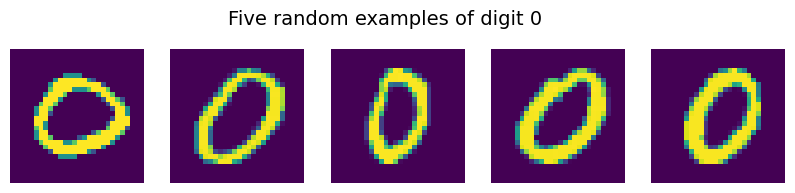

In [101]:
digit = 0 # Digit we want to display

# Find the indexes of the images with the same digit
indices = np.where(label == digit)[0]  
# Select five images at random
chosen_indices = np.random.choice(indices, 5, replace=False)  

fig, axs = plt.subplots(1, 5, figsize=(10, 2.2)) 
for i, idx in enumerate(chosen_indices):
    axs[i].imshow(features[idx].reshape(28, 28))
    axs[i].axis("off") 

plt.suptitle(f"Five random examples of digit {digit}", fontsize=14)
plt.show()

We observe a significant variability in how different patterns of the same digit appear. Therefore, averaging each digit’s images to create a final pattern seems like a reasonable approach to reduce instability.

Additionally, the images are not yet binarized with spins (+1, -1), as required by the Hopfield model. Moreover, many background pixels in the images do not contain relevant information for retrieving the digit and can be removed.

For these reasons, in the following steps, we will compute the average of the images, binarize the data, and crop the dataset accordingly.

In [102]:
# Fill the matrices
patterns, labels = select_average_images(features, label)
print(np.shape(patterns))
print(labels)

# Binarize data
patterns = binarize_image(patterns)

# Crop dataset
patterns = crop_dataset(patterns, border_width=4)
print("New shape:", np.shape(patterns))

(10, 784)
[0 1 2 3 4 5 6 7 8 9]
New shape: (10, 400)


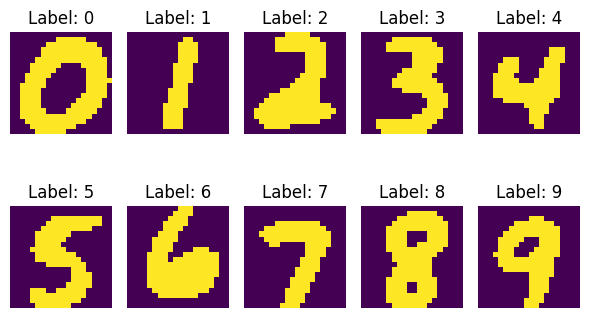

In [103]:
# Visualize images
fig, axs = plt.subplots(2, 5, figsize=(6, 4))
axs = axs.ravel()  

for p, l in zip(patterns, labels):
    
    axs[l].imshow(p.reshape(20, 20))
    axs[l].set_title(f"Label: {l}")
    axs[l].axis("off")

plt.tight_layout()
plt.show()

This is how our final set of patterns looks like.

### Now we are ready to test the three models in the dataset that we have just processed

## 1. Deterministic Hopfield

In this section, we will use the asynchronous retrieval method.

In [104]:
class HopfieldNet:
    def __init__(self, N, patterns):
        """
        Initialize the Hopfield Network.
        
        Parameters:
        N (int): Number of neurons.
        patterns (list of numpy arrays): List of stored patterns, each with shape (N,).
        """
        self.N = N
        self.patterns = patterns  # Store patterns for later analysis
        self.state = np.ones(N)  # Initialize neurons to +1 state
        
        # Initialize weight matrix using Hebbian learning
        self.w = np.zeros((N, N))
        self.learn_patterns(patterns)
        
    def learn_patterns(self, patterns):
        """
        Store patterns in the weight matrix using the Hebbian learning rule.
        """
        M = len(patterns)
        for p in patterns:
            self.w += np.outer(p, p)
        self.w /= M
        np.fill_diagonal(self.w, 0)  # Ensure no self-connections

    def set_state(self, input_pattern):
        """
        Set the current state of the network.
        
        Parameters:
        input_pattern (numpy array): Initial input pattern of shape (N,).
        """
        self.state = np.copy(input_pattern)

    def energy(self):
        """
        Compute the energy of the current state.
        """
        return -0.5 * np.dot(self.state, np.dot(self.w, self.state))

    def evolve_synchronous(self, steps):
        """
        Perform synchronous updates until convergence.
        """
        for _ in range(steps):
            new_state = np.sign(np.dot(self.w, self.state))
            if np.array_equal(new_state, self.state):
                break  # Stop if convergence is reached
            self.state = new_state

    def evolve_asynchronous(self, steps):
        """
        Perform asynchronous updates until convergence.
        """
        for _ in range(steps):
            i = np.random.randint(0, self.N)  # Randomly select a neuron
            h_i = np.dot(self.w[i], self.state)
            self.state[i] = np.sign(h_i)
    
    def retrieve(self, use_asynchronous=False, steps=100):
        """
        Retrieve the attractor pattern by evolving the network.
        
        Parameters:
        use_asynchronous (bool): If True, use asynchronous updates. Default is False (synchronous).
        steps (int): Number of update steps.
        """
        if use_asynchronous:
            self.evolve_asynchronous(steps)
        else:
            self.evolve_synchronous(steps)
        return self.state

True label: 0, Predicted label: 0


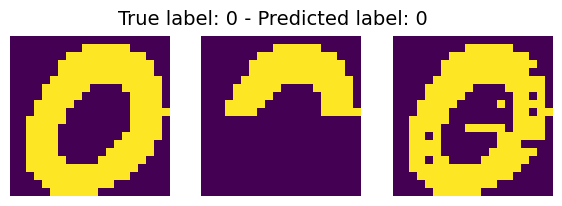

True label: 1, Predicted label: 1


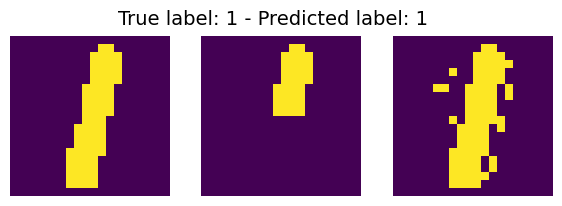

True label: 2, Predicted label: 2


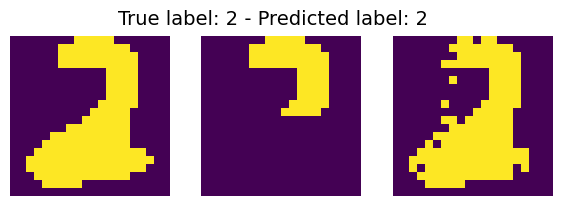

True label: 3, Predicted label: 3


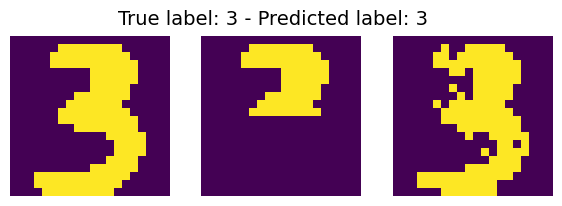

True label: 4, Predicted label: 4


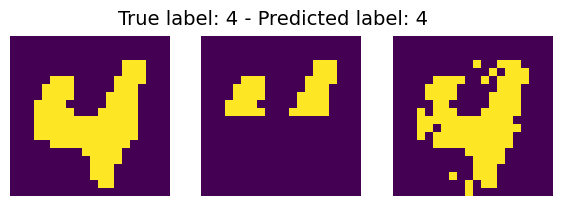

True label: 5, Predicted label: 5


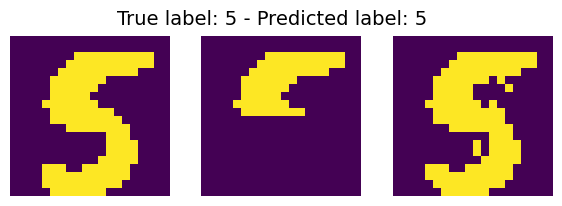

True label: 6, Predicted label: 6


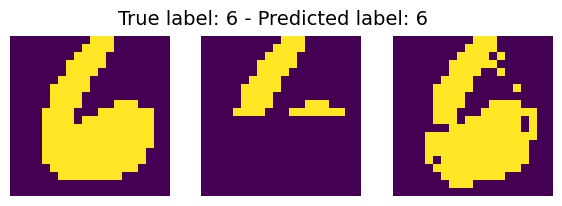

True label: 7, Predicted label: 7


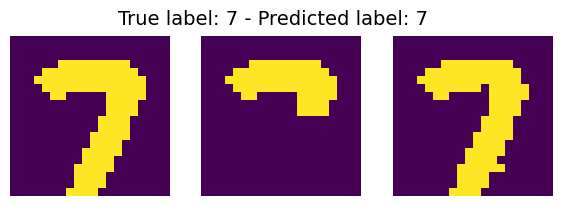

True label: 8, Predicted label: 8


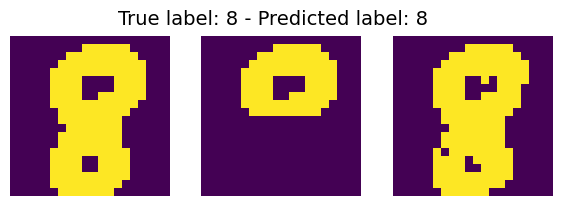

True label: 9, Predicted label: 9


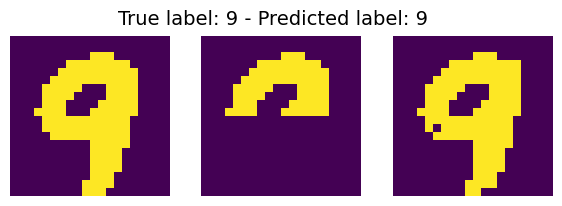

In [105]:
# Initialize the model
hopfield = HopfieldNet(patterns.shape[1], patterns)

# Store the patterns
hopfield.learn_patterns(patterns)

for p, true_label in zip(patterns, labels):
    # Corrupt the pattern
    hopfield.set_state(p)
    cut = cut_image(p, "up")
    
    # Recover the pattern
    recovered = hopfield.retrieve(True, steps=100)
    
    # Predict and print the label
    predicted_label = predict_label(recovered, patterns, labels)
    print(f"True label: {true_label}, Predicted label: {predicted_label}")
    
    # Plot
    plt.figure(figsize=(7, 2.2))
    for i, img in enumerate([p, cut, recovered]):
        plt.subplot(1, 3, i+1)
        plt.imshow(img.reshape(20, 20))
        plt.axis('off')
    plt.suptitle(f"True label: {true_label} - Predicted label: {predicted_label}", fontsize=14)
    plt.show()

We observe that, after 100 iterations in the asynchronous case, we can correctly predict all the corrupted digits, even though the final results do not perfectly match the original patterns.

To gain deeper insight into the energy landscape, we aim to increase the number of iterations in the retrieval process for each digit. This will help us determine the optimal number of steps needed for effective reconstruction.

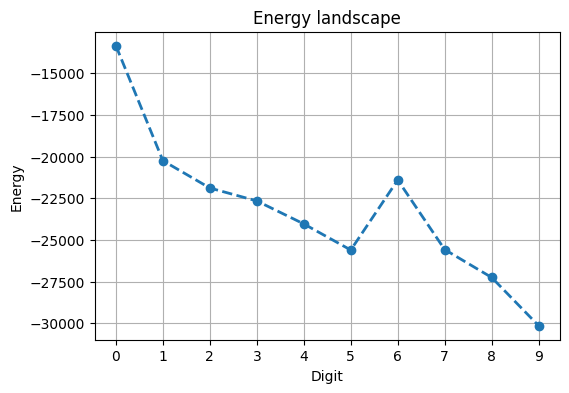

In [106]:
# List for the energy values
energies = []

# Compute the energy for each pattern and append it in the array
for idx, p in enumerate(patterns):

    hopfield.set_state(p)
    energies.append(hopfield.energy())

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 10, 1), energies, marker="o", linestyle="--", linewidth=2)
plt.xticks(np.arange(10))

plt.xlabel("Digit")
plt.ylabel("Energy")
plt.title("Energy landscape")
plt.grid()
plt.show()

From this plot is clear that we have a global minimum in correspondance of the digit 9, so we expect that, increasing the number of iterations, the model will always retrieve that digit.

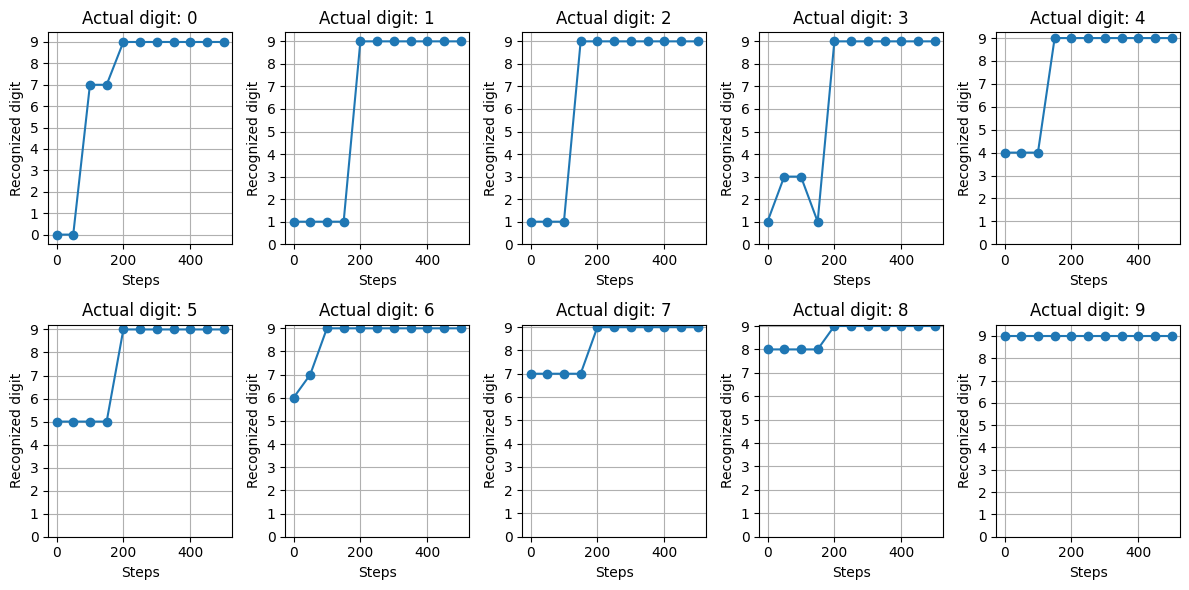

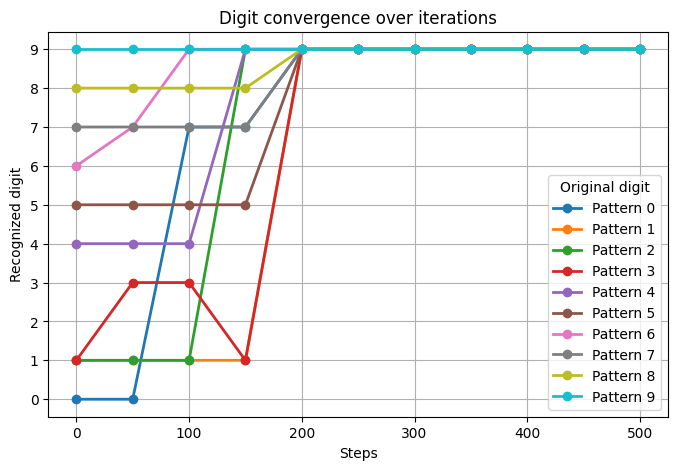

In [107]:
# Define iterations range
steps_max = 500
step_increment = 50 
steps_values = np.arange(0, steps_max + 1, step_increment)

# List to save the digits for each iteration
recognized_digits_all = [] 

for p, true_label in zip(patterns, labels):
    recognized_steps = []  

    # Corrupt the pattern
    hopfield.set_state(p)
    corrupted = cut_image(p, "up")

    # Set the initial state
    hopfield.set_state(corrupted) 

    # Evolve the system and record the convergence 
    for s in steps_values:
        hopfield.evolve_asynchronous(s) 

        recovered = hopfield.state.copy()
        # Predict the label
        predicted_label = predict_label(recovered, patterns, labels)
        recognized_steps.append(predicted_label)

    recognized_digits_all.append(recognized_steps)

# Convergence plot
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, rec in enumerate(recognized_digits_all):
    row, col = divmod(i, 5)

    axs[row, col].plot(steps_values, rec, marker='o', linestyle='-')
    axs[row, col].set_title(f"Actual digit: {labels[i]}")
    axs[row, col].set_xlabel("Steps")
    axs[row, col].set_ylabel("Recognized digit")
    axs[row, col].set_yticks(np.arange(10))
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

# General plot
plt.figure(figsize=(8, 5))
for i, rec in enumerate(recognized_digits_all):
    plt.plot(steps_values, rec, marker='o', linestyle='-', linewidth=2, label=f"Pattern {labels[i]}")

plt.xlabel("Steps")
plt.ylabel("Recognized digit")
plt.title("Digit convergence over iterations")
plt.yticks(np.arange(10))
plt.grid(True)
plt.legend(title="Original digit", loc="best")
plt.show()

The results of these plots show that if we significantly increase the number of iterations, the retrieval process eventually converges to the digit 9, as predicted by analyzing the energy landscape. However, if we limit the iterations to approximately 150 steps, the model successfully retrieves the original pattern, although some spins may not be perfectly aligned.

## 2. Montecarlo

For the second method we will use the analysis made before to choose the parameters that works better for the retrieval purpose. In particular we will use a thermal noise T=0.1 with a number of iteration of 200 steps.

True label: 0, Predicted label: 9
Mattis overlap: 0.42


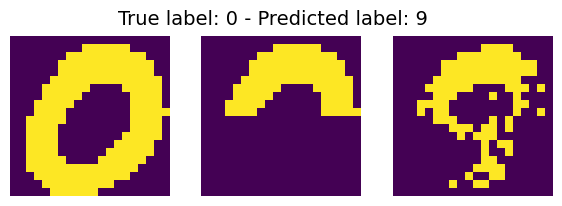

True label: 1, Predicted label: 1
Mattis overlap: 0.715


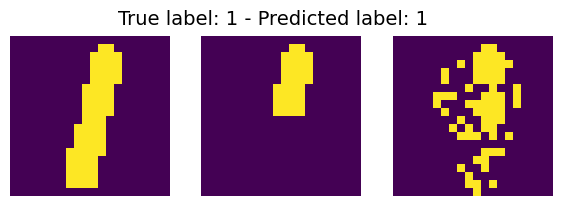

True label: 2, Predicted label: 9
Mattis overlap: 0.56


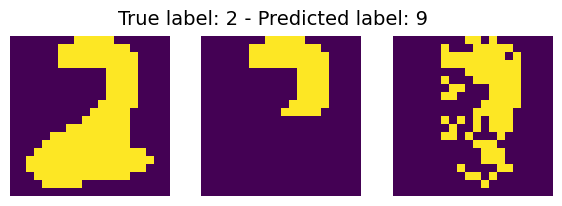

True label: 3, Predicted label: 3
Mattis overlap: 0.65


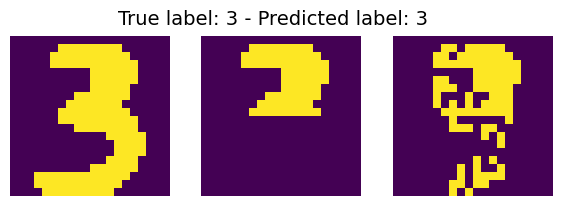

True label: 4, Predicted label: 4
Mattis overlap: 0.66


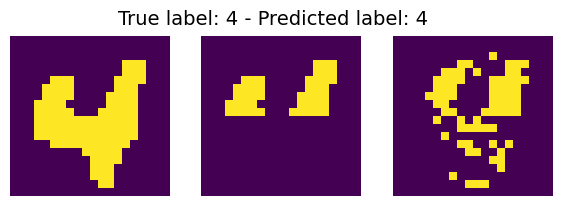

True label: 5, Predicted label: 5
Mattis overlap: 0.655


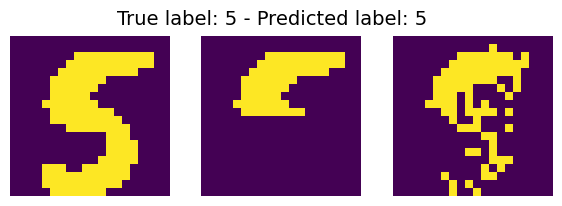

True label: 6, Predicted label: 9
Mattis overlap: 0.47500000000000003


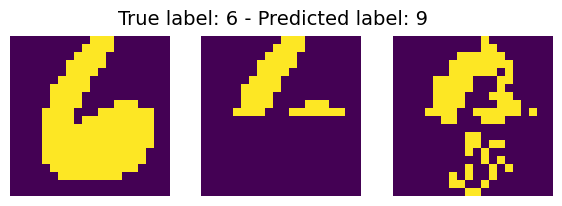

True label: 7, Predicted label: 7
Mattis overlap: 0.8150000000000001


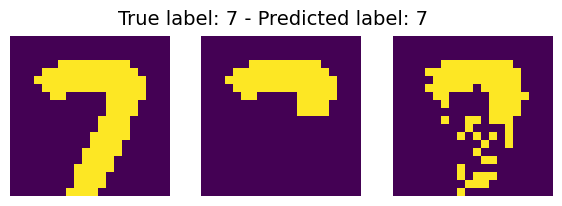

True label: 8, Predicted label: 9
Mattis overlap: 0.635


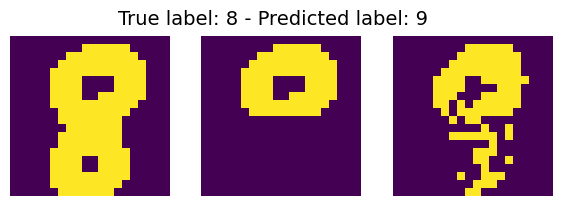

True label: 9, Predicted label: 9
Mattis overlap: 0.795


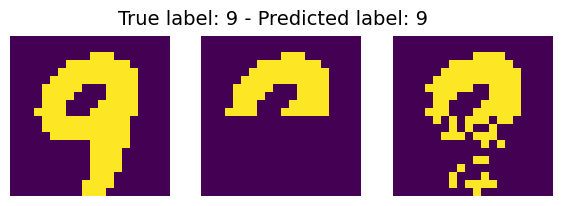

In [108]:
# Compute the weights matrix
J = compute_weights_1d(patterns) 

T = 0.1 # thermal noise
steps = 200 # number of iterations

for p, true_label in zip(patterns, labels):

    original = p  

    # Corrupt the pattern
    corrupted = cut_image(original, "up")

    # Recover the pattern 
    retrieved_pattern = metropolis_1d(corrupted, J, T, steps)
    
    # Predict labels
    predicted_label = predict_label(retrieved_pattern, patterns, labels)
    
    # Print the results
    print(f"True label: {true_label}, Predicted label: {predicted_label}")
    print("Mattis overlap:", mattis_overlap_1d(original, retrieved_pattern))
    
    # Plot
    plt.figure(figsize=(7, 2.2))
    for i, img in enumerate([p, corrupted, retrieved_pattern]):
        plt.subplot(1, 3, i+1)
        plt.imshow(img.reshape(20, 20))
        plt.axis('off')
    plt.suptitle(f"True label: {true_label} - Predicted label: {predicted_label}", fontsize=14)
    plt.show()

In this case, the retrieval process did not perform well; even with the optimal choice of parameters, the digits were not correctly reconstructed.

One possible guess is that, since the corruption method (cutting half of the image) is not random, due to the stochasticity of the Monte Carlo fails to effectively reconstruct the missing patterns.

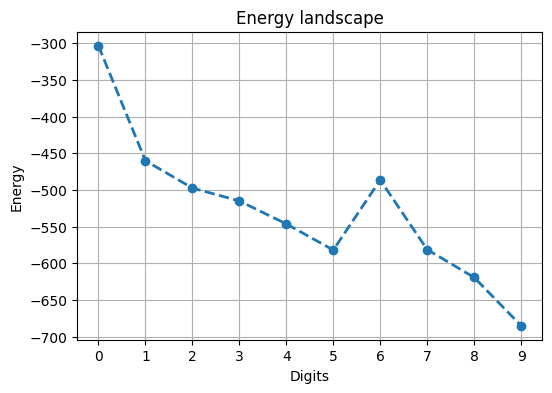

In [109]:
# Plot the energy landscape
energies = []
for p in patterns:
    energies.append(compute_energy_1d(p, J))
    
plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 10, 1), energies, marker="o", linestyle="--", linewidth=2)
plt.xticks(np.arange(10))
plt.title("Energy landscape")
plt.xlabel("Digits")
plt.ylabel("Energy")
plt.grid()
plt.show()

Even in that case the energy lanscape is similar than before with a global minimum in correspondance of the digit 9.

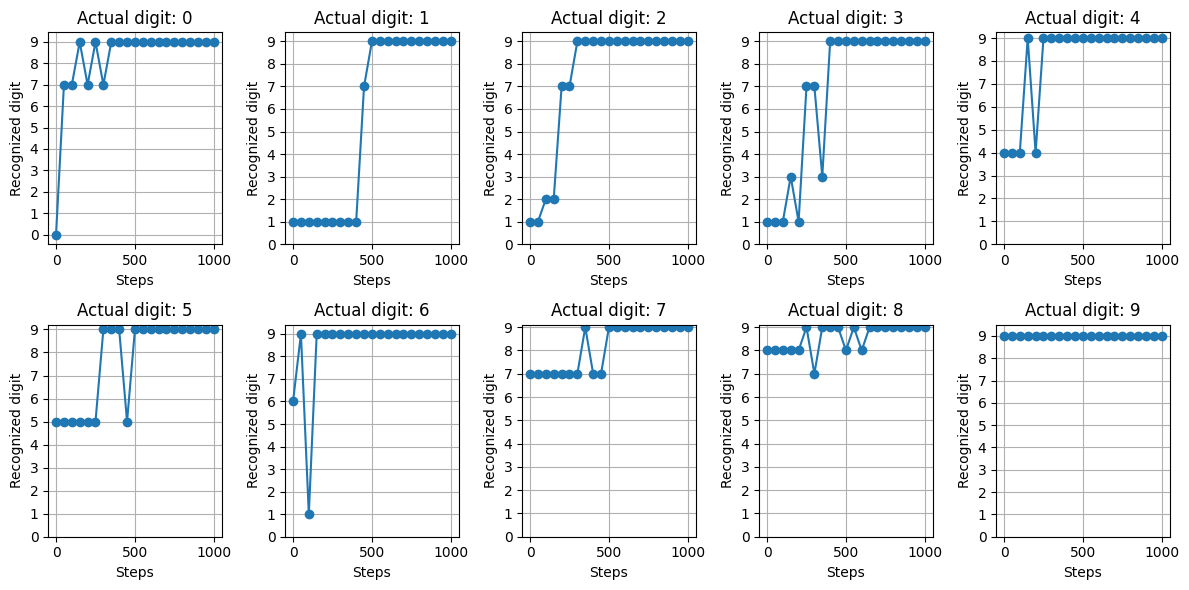

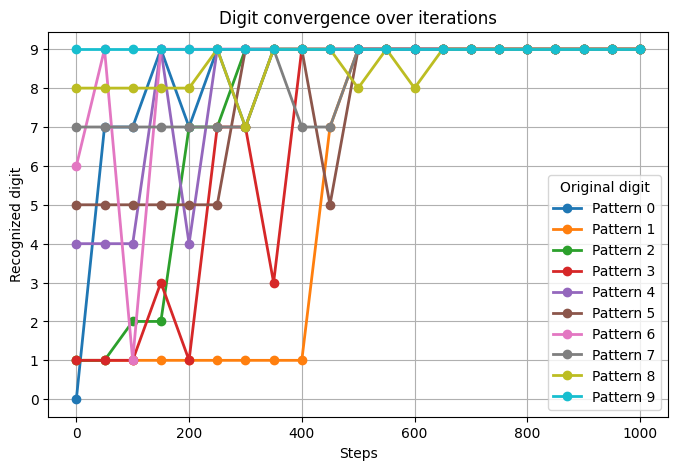

In [110]:
# Define iterations range
steps_max = 1000   
step_increment = 50 
steps_values = np.arange(0, steps_max+1, step_increment) 

recognized_digits_all = []  
for idx, (p, original_digit) in enumerate(zip(patterns, labels)):
    recognized_steps = []  

    for s in steps_values:

        corrupted = cut_image(p, "up")  
        retrieved = metropolis_1d(corrupted, J, T, int(s))
        
        overlaps = [mattis_overlap_1d(stored, retrieved) for stored in patterns]
        recognized_digit = np.argmax(overlaps)  # take the index with the max overlap
        recognized_steps.append(recognized_digit)
        
    recognized_digits_all.append(recognized_steps)


# Convergence plot
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, rec in enumerate(recognized_digits_all):
    row, col = divmod(i, 5)

    axs[row, col].plot(steps_values, rec, marker='o', linestyle='-')
    axs[row, col].set_title(f"Actual digit: {labels[i]}")
    axs[row, col].set_xlabel("Steps")
    axs[row, col].set_ylabel("Recognized digit")
    axs[row, col].set_yticks(np.arange(10))
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

# General plot
plt.figure(figsize=(8, 5))
for i, rec in enumerate(recognized_digits_all):
    plt.plot(steps_values, rec, marker='o', linestyle='-', linewidth=2, label=f"Pattern {labels[i]}")

plt.xlabel("Steps")
plt.ylabel("Recognized digit")
plt.title("Digit convergence over iterations")
plt.yticks(np.arange(10))
plt.grid(True)
plt.legend(title="Original digit", loc="best")
plt.show()

The interpretation of these plots remains the same as before: increasing the number of iterations inevitably leads to convergence to the digit 9.

However, in this case, the plot appears more chaotic for a lower number of steps (below 400), making it difficult to determine a clear threshold under which the pattern retrieval can be considered accurate.

## 3. Modern Hopfield

Finally, we will test the last implementation looking at the results with respect to the polynomial order and the number of epochs (steps).

True label: 0, Predicted label: 5


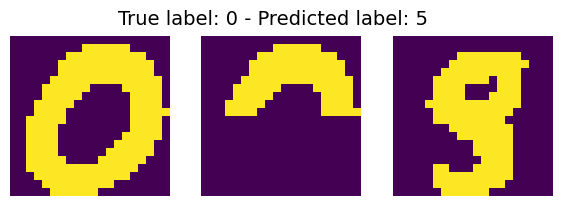

True label: 1, Predicted label: 1


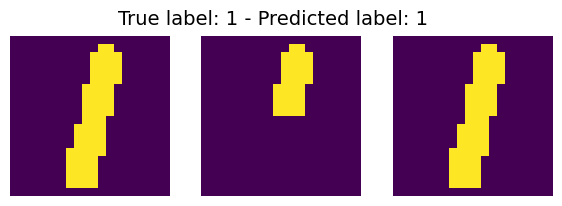

True label: 2, Predicted label: 1


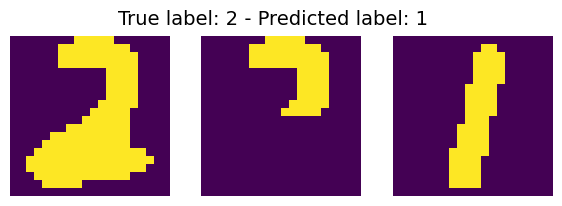

True label: 3, Predicted label: 7


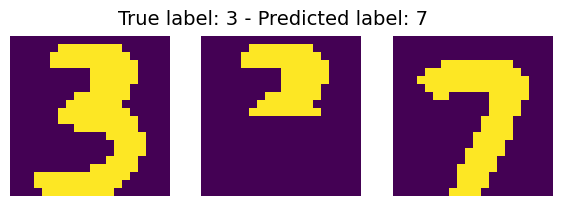

True label: 4, Predicted label: 4


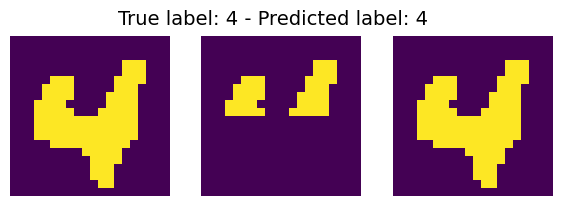

True label: 5, Predicted label: 5


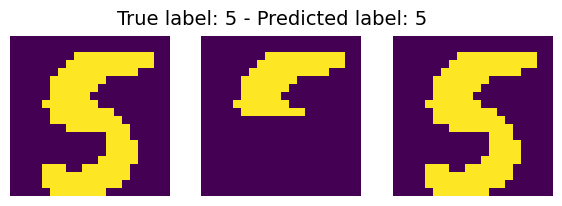

True label: 6, Predicted label: 9


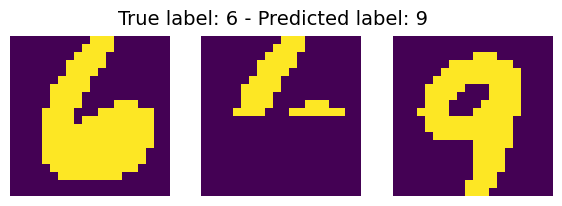

True label: 7, Predicted label: 7


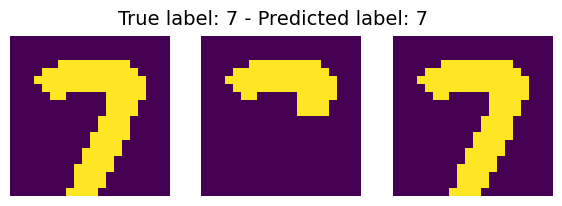

True label: 8, Predicted label: 9


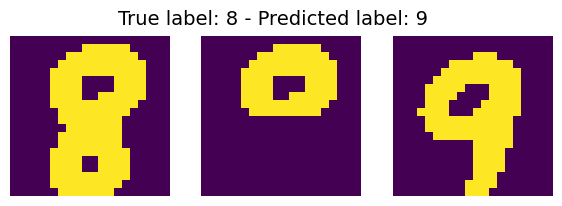

True label: 9, Predicted label: 9


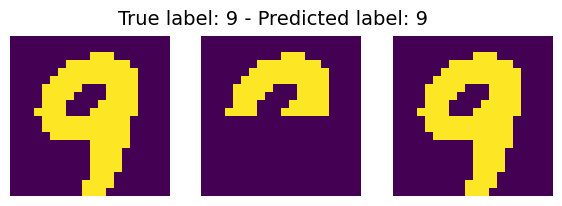

In [116]:
# Create the object
m_hopfield = modern_hopfield(pattern_lenght=400, poly_deg=7)

# Store the patterns
patterns = np.array(patterns)
m_hopfield.add_patterns(patterns)

for p, true_label in zip(patterns, labels):
    # Corrupt the pattern
    cut = cut_image(p, "up")

    # Recover the pattern
    recovered = m_hopfield.retrieve_pattern(cut, epochs=5)
    
    # Predict and print the label
    predicted_label = predict_label(recovered, patterns, labels)
    print(f"True label: {true_label}, Predicted label: {predicted_label}")
    
    # Plot
    plt.figure(figsize=(7, 2.2))
    for i, img in enumerate([p, cut, recovered]):
        plt.subplot(1, 3, i+1)
        plt.imshow(img.reshape(20, 20))
        plt.axis('off')
    plt.suptitle(f"True label: {true_label} - Predicted label: {predicted_label}", fontsize=14)
    plt.show()

Now, while not all the patterns are correctly classified, the overall shape of the retrieved digits remains accurate.

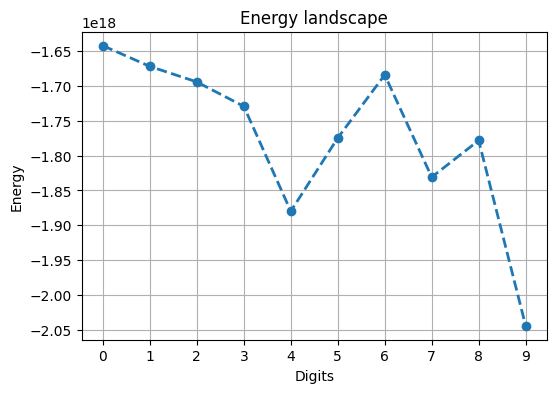

In [112]:
# Plot of the energy landscape
energies = []
for p in patterns:
    E = m_hopfield.energy(p)  
    energies.append(E)

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 10, 1), energies, marker="o", linestyle="--", linewidth=2)
plt.xticks(np.arange(10))
plt.title("Energy landscape")
plt.xlabel("Digits")
plt.ylabel("Energy")
plt.grid()
plt.show()

The energy landscape, as observed before, has a global minimum at digit 9. Therefore, we expect that increasing the number of epochs significantly will cause all digits to converge to 9.

As some digits are not correctly classified, we want to see how their shape change with respect to the number of epochs.
We set the max number of epochs to 10 and we let our system evolve.

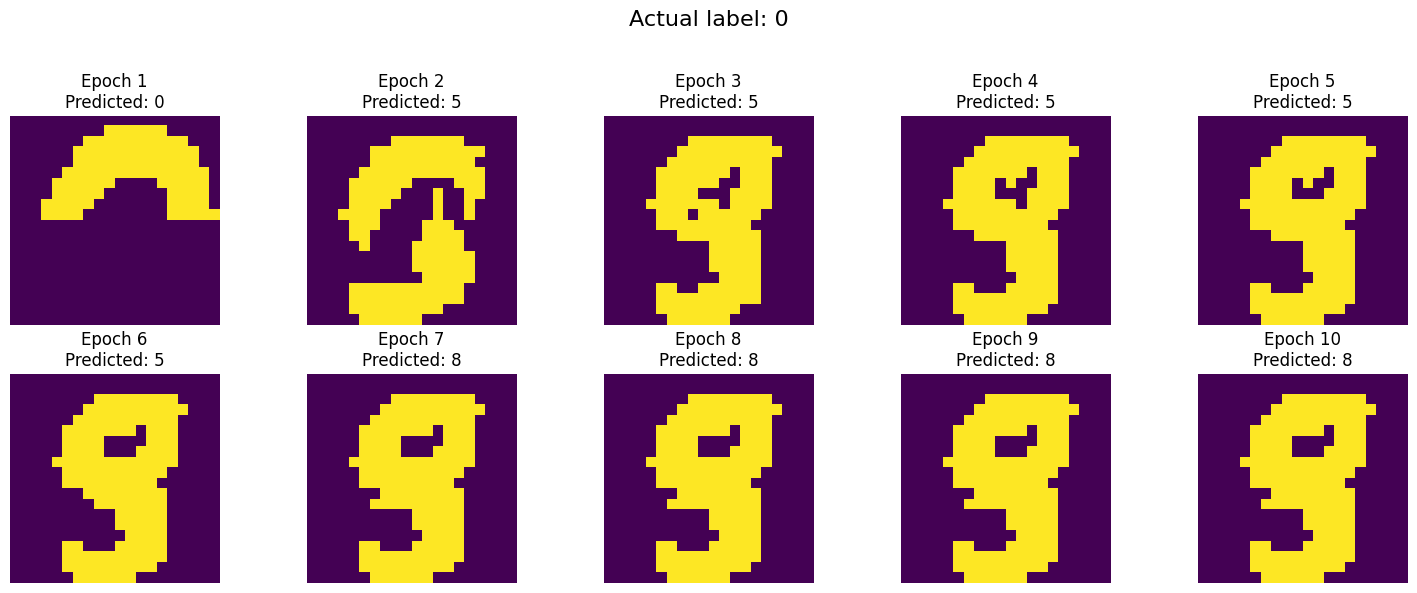

In [113]:
i = 0  # label of the pattern we want to test

# Define the original pattern and label and corrupt it
original = patterns[i]        
actual_label = labels[i]       
corrupted = cut_image(original, "up")  

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()  

for epoch in range(10):
    # Recover the pattern for the given epoch 
    retrieved = m_hopfield.retrieve_pattern(p=corrupted, epochs=epoch)
    predicted_label = predict_label(retrieved, patterns, labels)
    
    # Plot
    axes[epoch].imshow(retrieved.reshape(20, 20))
    axes[epoch].set_title(f"Epoch {epoch+1}\nPredicted: {predicted_label}")
    axes[epoch].axis("off")

plt.suptitle(f"Actual label: {actual_label}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

As predicted from the energy landscape, since digit 0 corresponds to an energy maximum, the network fails to retrieve the correct pattern and instead converges to a digit with lower energy.

At the end we want to perform a last analysis in order to understand how the order of the polynomial we choose, influence the accuracy in the retrieval process.

Poly order: 0, accuracy: 10.0%
Poly order: 1, accuracy: 10.0%
Poly order: 2, accuracy: 10.0%
Poly order: 3, accuracy: 10.0%
Poly order: 4, accuracy: 20.0%
Poly order: 5, accuracy: 30.0%
Poly order: 6, accuracy: 50.0%
Poly order: 7, accuracy: 50.0%
Poly order: 8, accuracy: 10.0%
Poly order: 9, accuracy: 0.0%


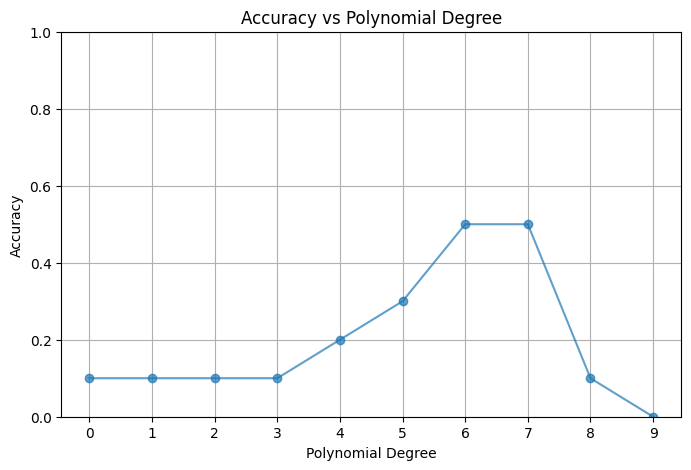

In [114]:
# Define the polynomial degrees vector
poly_orders = [i for i in range(10)]
accuracies = []

for poly_order in poly_orders:
    # Initialize the network with a given degree
    m_hopfield = modern_hopfield(pattern_lenght=400, poly_deg=poly_order)
    m_hopfield.add_patterns(np.array(patterns))

    correct_predictions = 0
    total_predictions = len(patterns)

    for p, true_label in zip(patterns, labels):
        # Corrupt the pattern
        cut = cut_image(p, "up")
        
        # Retrieve the pattern
        recovered = m_hopfield.retrieve_pattern(cut, epochs=5)
        
        # Predict the label
        predicted_label = predict_label(recovered, patterns, labels)

        # Count correct predictions
        if predicted_label == true_label:
            correct_predictions += 1

    # Compute the correctness for the polynomial degree
    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)
    print(f"Poly order: {poly_order}, accuracy: {accuracy*100}%")

# Plot 
plt.figure(figsize=(8, 5))
plt.plot(poly_orders, accuracies, marker='o', linestyle='-', alpha=0.7)
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Polynomial Degree")
plt.xticks(poly_orders)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

As we did, the best choice is a polynomial degree of 6 or 7.

# Conclusions